# Aeronautical Occurrences in Brazilian Civil Aviation

In this notebook we perform an exploratory data analysis process in the Brazilian public database _Ocorrências Aeronáuticas na Aviação Civil Brasileira_.

The database in composed of the following files:

* _dicionario-de-dados.pdf_: a PDF file containing the data mode with column description and relationship between the other data files.
* _aeronave.csv_: a table containing the aircraft detailed information.
* _ocorrencia.csv_: a table containing aeronautical ocurrences detailed information.

*NOTE*: _dicionario-de-dados.pdf_ file mention a third table called _fator-contribuinte.csv_, however this file is not available in the link provided to download the database.

## Setup and imports

In [1]:
import os
from pathlib import Path

import folium
import geopandas as gpd
import missingno as mno
import numpy as np
import pandas as pd
import seaborn as sns

from folium import Map, Marker, PolyLine
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt
from scipy.stats import normaltest

sns.set_theme(style='whitegrid')

%matplotlib inline

In [2]:
DATA_ROOT = Path('data/')

## Data loading

In this first step we loaded the data following the description table provided by _dicionario-de-dados_ file.

In [3]:
aircraft_df = pd.read_csv(DATA_ROOT / 'aeronave.csv', na_values=['***', '****'], parse_dates=['dia_extracao'], infer_datetime_format=True)
aircraft_df.head()

codigo_aeronave  codigo_ocorrencia matricula  codigo_operador equipamento  \
0                4              45602     PPGXE              241       AVIÃO   
1               40              53551     PPGSZ              160       AVIÃO   
2              118              43721     PTCMT             1232       AVIÃO   
3              130              35556     PTEQI             3992       AVIÃO   
4              191              32579     PPVMM             4365       AVIÃO   

                    fabricante    modelo tipo_motor  quantidade_motores  \
0  NEIVA INDUSTRIA AERONAUTICA      56-C     PISTÃO                 1.0   
1  NEIVA INDUSTRIA AERONAUTICA      56-C     PISTÃO                 1.0   
2               BEECH AIRCRAFT    95-B55     PISTÃO                 2.0   
3  NEIVA INDUSTRIA AERONAUTICA  EMB-721C     PISTÃO                 1.0   
4               BOEING COMPANY   737-241       JATO                 2.0   

   peso_maximo_decolagem  ...  pais_registro  categoria_registro  \
0                    660  ...         BRASIL                 PRI   
1                    660  ...         BRASIL                 PRI   
2                   2310  ...         BRASIL                 TPX   
3                   1633  ...         BRASIL                 TPP   
4                  52389  ...         BRASIL                 TPR   

  categoria_aviacao origem_voo destino_voo       fase_operacao tipo_operacao  \
0         INSTRUÇÃO       SDPW        SDPW       INDETERMINADA     INSTRUÇÃO   
1         INSTRUÇÃO       SBBP        SBBP           DECOLAGEM     INSTRUÇÃO   
2        TÁXI AÉREO        NaN         NaN  CORRIDA APÓS POUSO    TÁXI AÉREO   
3        PARTICULAR       SNDU        SBSL  CORRIDA APÓS POUSO       PRIVADA   
4           REGULAR        NaN         NaN              SUBIDA       REGULAR   

    nivel_dano quantidade_fatalidades dia_extracao  
0  SUBSTANCIAL                    NaN   2016-07-30  
1         LEVE                    NaN   2016-07-30  
2  SUBSTANCIAL                    NaN   2016-07-30  
3         LEVE                    NaN   2016-07-30  
4       NENHUM                    NaN   2016-07-30  

[5 rows x 22 columns]

In [4]:
# Checking dtypes according to the data dictionary
aircraft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   codigo_aeronave         2043 non-null   int64         
 1   codigo_ocorrencia       2043 non-null   int64         
 2   matricula               2043 non-null   object        
 3   codigo_operador         2043 non-null   int64         
 4   equipamento             2038 non-null   object        
 5   fabricante              1933 non-null   object        
 6   modelo                  2028 non-null   object        
 7   tipo_motor              2015 non-null   object        
 8   quantidade_motores      2034 non-null   float64       
 9   peso_maximo_decolagem   2043 non-null   int64         
 10  quantidade_assentos     2025 non-null   float64       
 11  ano_fabricacao          2039 non-null   float64       
 12  pais_registro           2043 non-null   object  

In [5]:
aircraft_df['peso_maximo_decolagem'] = aircraft_df['peso_maximo_decolagem'].astype('float64')

Some of the integer columns like `quantidade_motores` and `quantidades_assentos` are read as `float64` due to the missing values.

In [6]:
occurrence_df = pd.read_csv(DATA_ROOT / 'ocorrencia.csv', na_values=['***', '****'], parse_dates=[
    'dia_ocorrencia', 'horario', 'dia_publicacao', 'dia_extracao'
], infer_datetime_format=True)
occurrence_df.head()

codigo_ocorrencia    classificacao                       tipo  localidade  \
0              47965         ACIDENTE      FALHA DO MOTOR EM VOO   ARIQUEMES   
1              50313  INCIDENTE GRAVE             POUSO SEM TREM      CACOAL   
2              34078         ACIDENTE  PERDA DE CONTROLE NO SOLO  CEREJEIRAS   
3              44988         ACIDENTE                POUSO LONGO     AMAJARI   
4              38855         ACIDENTE   PERDA DE CONTROLE EM VOO      ACEGUÁ   

   uf    pais aerodromo dia_ocorrencia             horario sera_investigada  \
0  RO  BRASIL      SJOG     2013-05-05 2023-01-26 11:00:00              NaN   
1  RO  BRASIL      SSKW     2013-11-25 2023-01-26 12:32:00              SIM   
2  RO  BRASIL       NaN     2008-08-07 2023-01-26 15:10:00              SIM   
3  RR  BRASIL       NaN     2011-08-11 2023-01-26 17:00:00              SIM   
4  RS  BRASIL       NaN     2009-12-28 2023-01-26 17:30:00              SIM   

  comando_investigador status_investigacao     numero_relatorio  \
0             SERIPA-7                 NaN                  NaN   
1             SERIPA-7          FINALIZADA   IG-209/CENIPA/2013   
2             SERIPA-7          FINALIZADA  A - 517/CENIPA/2016   
3             SERIPA-7          FINALIZADA    A-105/CENIPA/2012   
4             SERIPA-5               ATIVA            A DEFINIR   

   relatorio_publicado dia_publicacao  quantidade_recomendacoes  \
0                  NaN            NaT                         0   
1                  1.0     2014-04-07                         0   
2                  1.0     2016-07-07                         0   
3                  1.0     2012-09-20                         4   
4                  NaN            NaT                         0   

   aeronaves_envolvidas  saida_pista dia_extracao  
0                     1          NaN   2016-07-30  
1                     1          NaN   2016-07-30  
2                     1          1.0   2016-07-30  
3                     1          NaN   2016-07-30  
4                     1          NaN   2016-07-30

In [7]:
# Checking dtypes according to the data dictionary
occurrence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         2027 non-null   int64         
 1   classificacao             2027 non-null   object        
 2   tipo                      2027 non-null   object        
 3   localidade                2027 non-null   object        
 4   uf                        2025 non-null   object        
 5   pais                      2027 non-null   object        
 6   aerodromo                 807 non-null    object        
 7   dia_ocorrencia            2027 non-null   datetime64[ns]
 8   horario                   2027 non-null   datetime64[ns]
 9   sera_investigada          1824 non-null   object        
 10  comando_investigador      2027 non-null   object        
 11  status_investigacao       1821 non-null   object        
 12  numero_relatorio    

During the data characterization step, we found some columns described as integer that we believe suits better as boolean columns. Thus, the next cell convert the `dtypes` of those columns in both of the tables.

In [8]:
occurrence_df['relatorio_publicado'] = occurrence_df['relatorio_publicado'].astype('bool')
occurrence_df['saida_pista'] = occurrence_df['saida_pista'].astype('bool')
occurrence_df['sera_investigada'] = occurrence_df['sera_investigada'].apply(lambda x: x == 'SIM')

## Data Characterization

Before going in further hypothesis and analysis, a good practice in the EDA process is get to know the characteristics of the data we're working with (e.g. possible values for categorical data, distribution shape of numerical data, missing values, etc). In this step we get these informations from this database to help us out in our data analysis.

### Missing values

codigo_aeronave              0
codigo_ocorrencia            0
matricula                    0
codigo_operador              0
equipamento                  5
fabricante                 110
modelo                      15
tipo_motor                  28
quantidade_motores           9
peso_maximo_decolagem        0
quantidade_assentos         18
ano_fabricacao               4
pais_registro                0
categoria_registro           9
categoria_aviacao           25
origem_voo                1110
destino_voo               1204
fase_operacao                0
tipo_operacao               26
nivel_dano                  69
quantidade_fatalidades    1688
dia_extracao                 0
dtype: int64

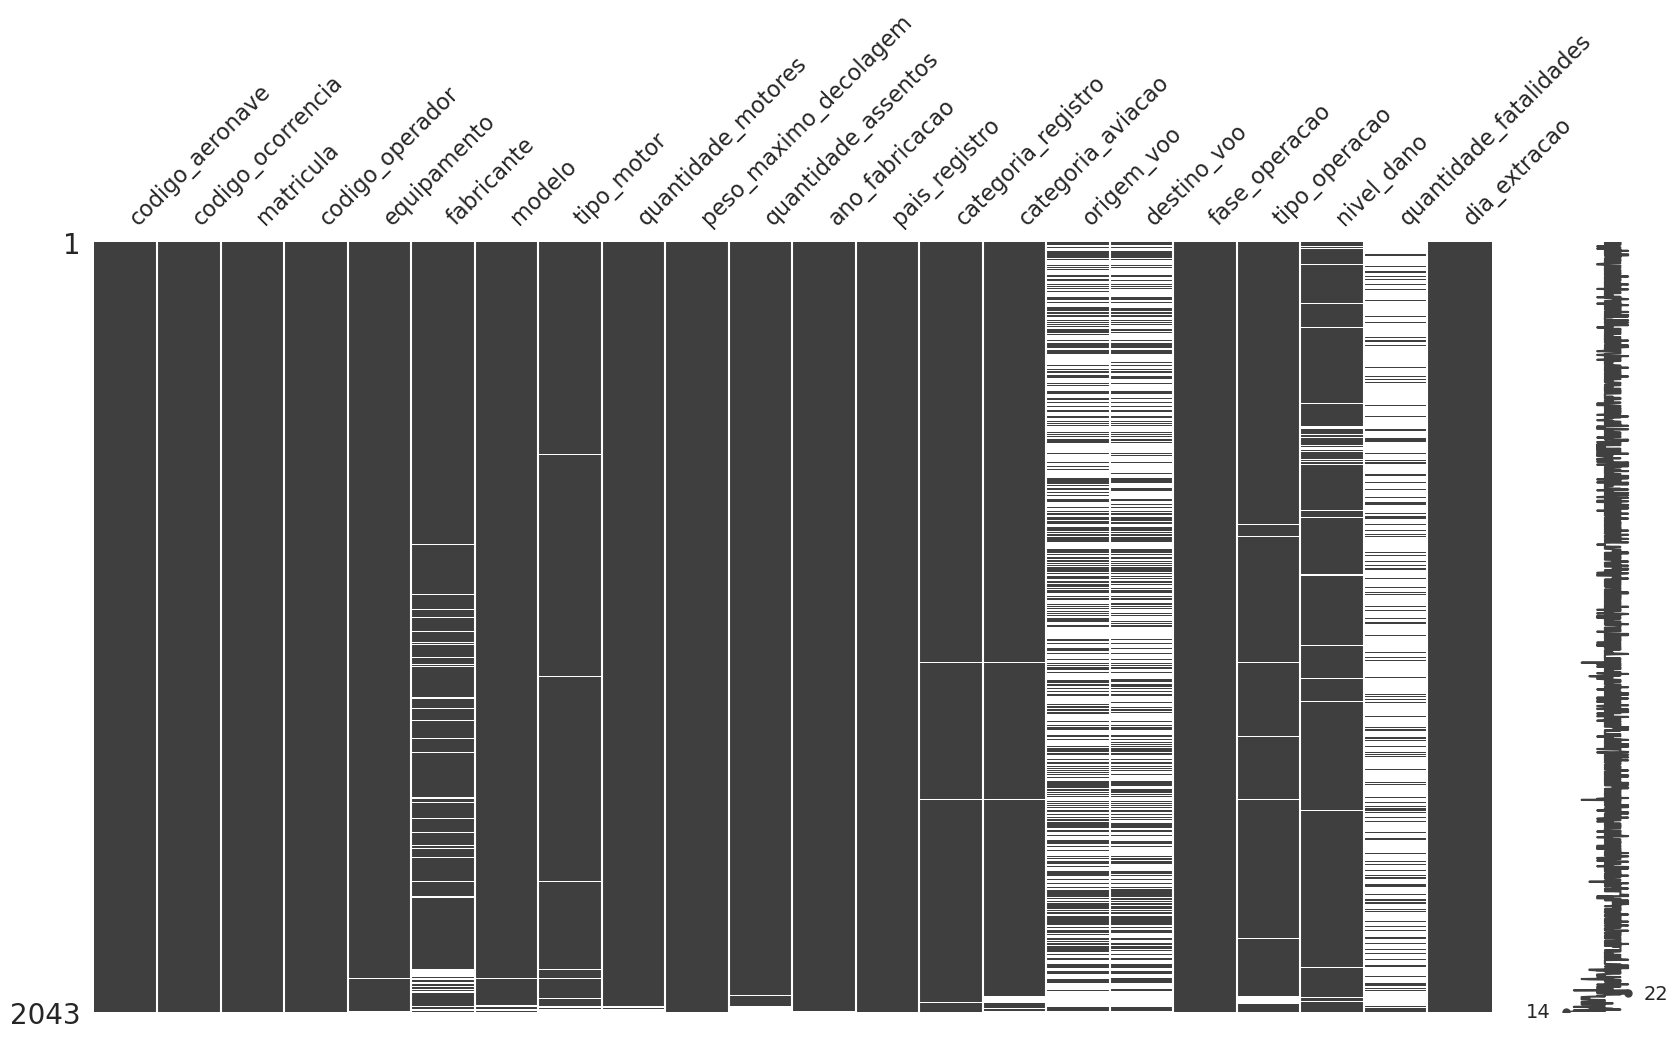

In [9]:
# Checking for null values
display(aircraft_df.isnull().sum(axis=0))
mno.matrix(aircraft_df, figsize=(20, 10))
plt.show()

As we can observe, the total number of deads are mostly missing in the aircraft table, making it difficult to propose a good machine learning model for this kind of prediction.

The origin and destination of the flights are also mostly missing, however they are not matching, despite their visual similarity.

All other columns with missing values are mostly filled in.

codigo_ocorrencia              0
classificacao                  0
tipo                           0
localidade                     0
uf                             2
pais                           0
aerodromo                   1220
dia_ocorrencia                 0
horario                        0
sera_investigada               0
comando_investigador           0
status_investigacao          206
numero_relatorio             206
relatorio_publicado            0
dia_publicacao              1032
quantidade_recomendacoes       0
aeronaves_envolvidas           0
saida_pista                    0
dia_extracao                   0
dtype: int64

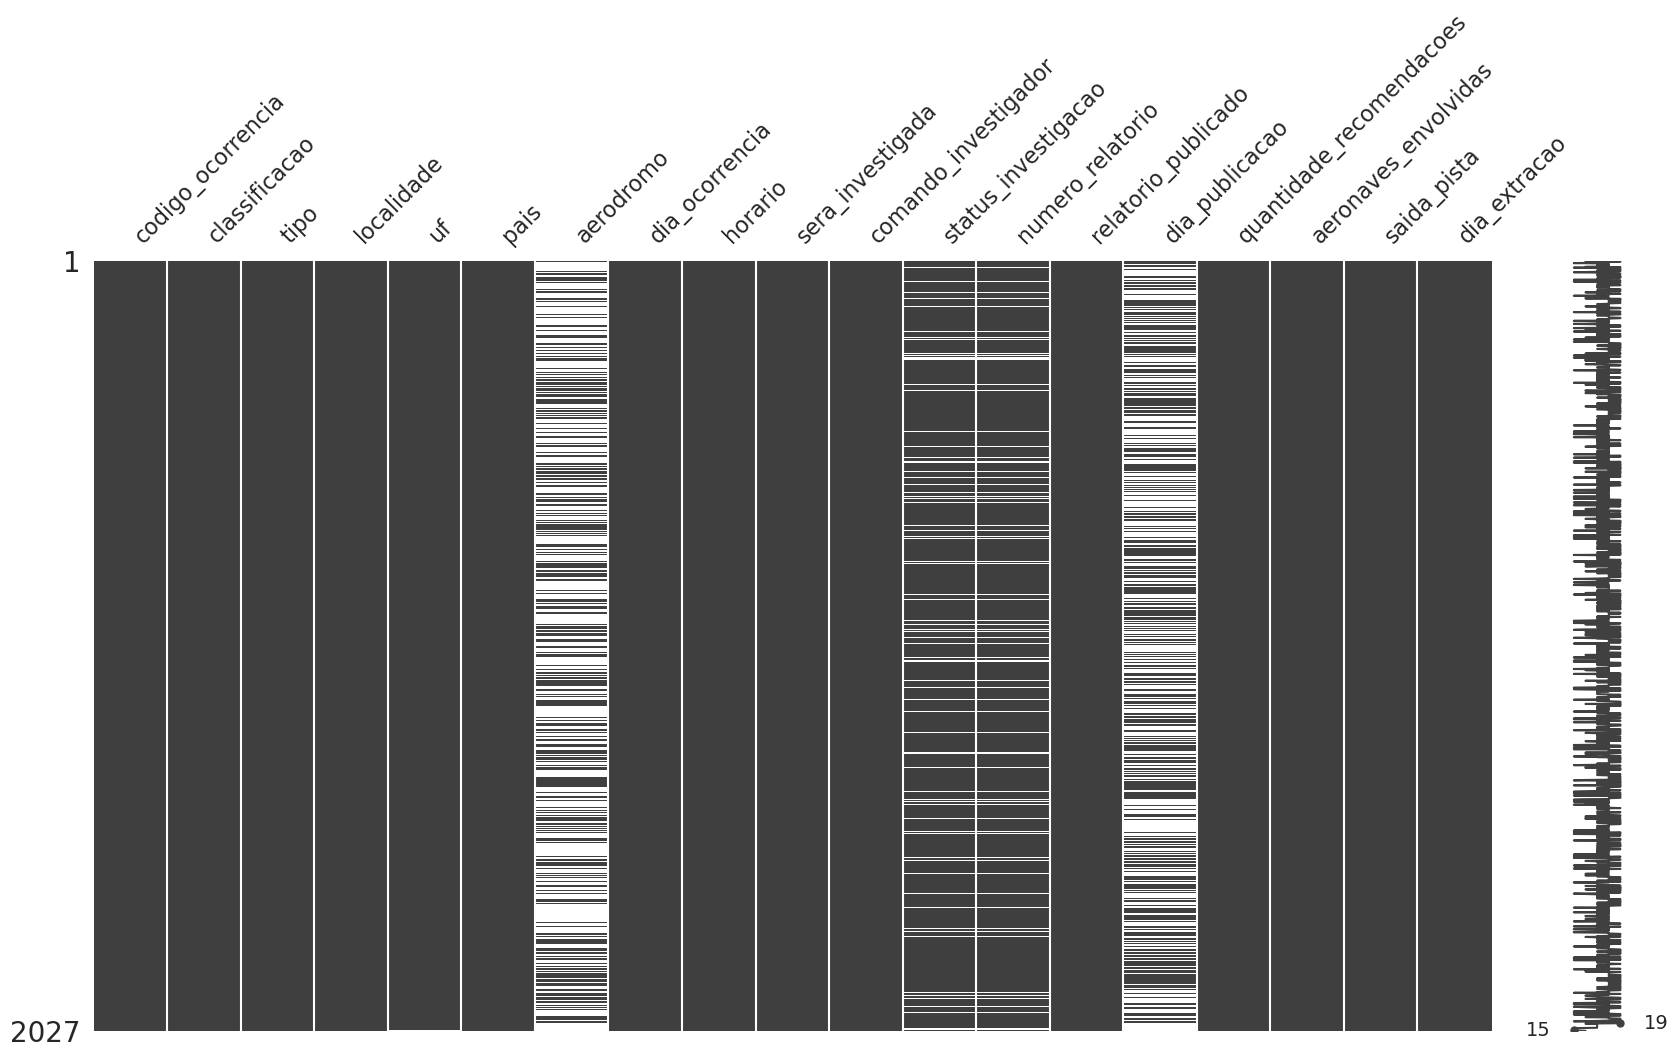

In [10]:
display(occurrence_df.isnull().sum(axis=0))
mno.matrix(occurrence_df, figsize=(20, 10))
plt.show()

We can check that `saida_pista` information is mostly missing. Without this information we're not able to make further inferences w.r.t. departures in the ocurrence.

Additionally, for the ocurrences table the missing values present more interesting information: some columns seem to match the missing ocurrence rows as we verified below.

In [11]:
print(f'All missing values rows from `status_investigacao` and `numero_relatorio` match each other: {(occurrence_df["status_investigacao"].isnull() == occurrence_df["numero_relatorio"].isnull()).all()}')

All missing values rows from `status_investigacao` and `numero_relatorio` match each other: True


In [12]:
occurrence_df[occurrence_df['sera_investigada'] == False][['status_investigacao', 'numero_relatorio']].isnull().sum(axis=0)

status_investigacao    205
numero_relatorio       205
dtype: int64

We can observe that all non investigated occurrences are missing values for `status_investigacao` and `numero_relatorio` columns. This is expected given that if there's no investigation, there's no status and no report.

In [13]:
aircraft_id_columns = ['codigo_aeronave', 'codigo_ocorrencia', 'codigo_operador']
ocurrence_id_columns = ['codigo_ocorrencia']

In [14]:
# Get all categorical columns
aircraft_categorical_columns = aircraft_df.select_dtypes(include=['object']).columns
occurrence_categorical_columns = occurrence_df.select_dtypes(include=['object']).columns

# Get all numerical columns
aircraft_numerical_columns = aircraft_df.select_dtypes(include=['int64', 'float64']).columns
aircraft_numerical_columns = [col for col in aircraft_numerical_columns if col not in aircraft_id_columns]

occurrence_numerical_columns = occurrence_df.select_dtypes(include=['int64', 'float64']).columns
occurrence_numerical_columns = [col for col in occurrence_numerical_columns if col not in ocurrence_id_columns]

# Get all datetime columns
aircraft_datetime_columns = aircraft_df.select_dtypes(include=['datetime64']).columns
occurrence_datetime_columns = occurrence_df.select_dtypes(include=['datetime64']).columns

### Categorical data

In [15]:
print('Aircraft table categorical description')
display(aircraft_df[aircraft_categorical_columns].describe())

print('Occurrence table categorical description')
display(occurrence_df[occurrence_categorical_columns].describe())

Aircraft table categorical description


matricula equipamento                   fabricante  modelo tipo_motor  \
count       2043        2038                         1933    2028       2015   
unique      1871           7                          119     514          5   
top        PPGOB       AVIÃO  NEIVA INDUSTRIA AERONAUTICA  AB-115     PISTÃO   
freq           4        1603                          388     111       1601   

       pais_registro categoria_registro categoria_aviacao origem_voo  \
count           2043               2034              2018        933   
unique            16                 23                12        392   
top           BRASIL                TPP        PARTICULAR       SBMT   
freq            2000                760               760         34   

       destino_voo fase_operacao tipo_operacao   nivel_dano  
count          839          2043          2017         1974  
unique         391            24             9            4  
top           SBMT         POUSO       PRIVADA  SUBSTANCIAL  
freq            25           391           775         1193

Occurrence table categorical description


classificacao                   tipo      localidade    uf    pais  \
count           2027                   2027            2027  2025    2027   
unique             2                     49             815    28       7   
top         ACIDENTE  FALHA DO MOTOR EM VOO  RIO DE JANEIRO    SP  BRASIL   
freq            1475                    377              64   434    2019   

       aerodromo comando_investigador status_investigacao numero_relatorio  
count        807                 2027                1821             1821  
unique       305                    9                   3             1223  
top         SBMT             SERIPA-4          FINALIZADA        A DEFINIR  
freq          18                  480                1059              433

There are some columns that we expected to have a unique value for each row: `matricula` and `numero_relatorio`. However, given the missing value count and the total unique values, the total do not match the length of the table.

This indicates that we can have same aircraft involved in more than one ocurrence, and that we can have same report number for more than one ocurrence.

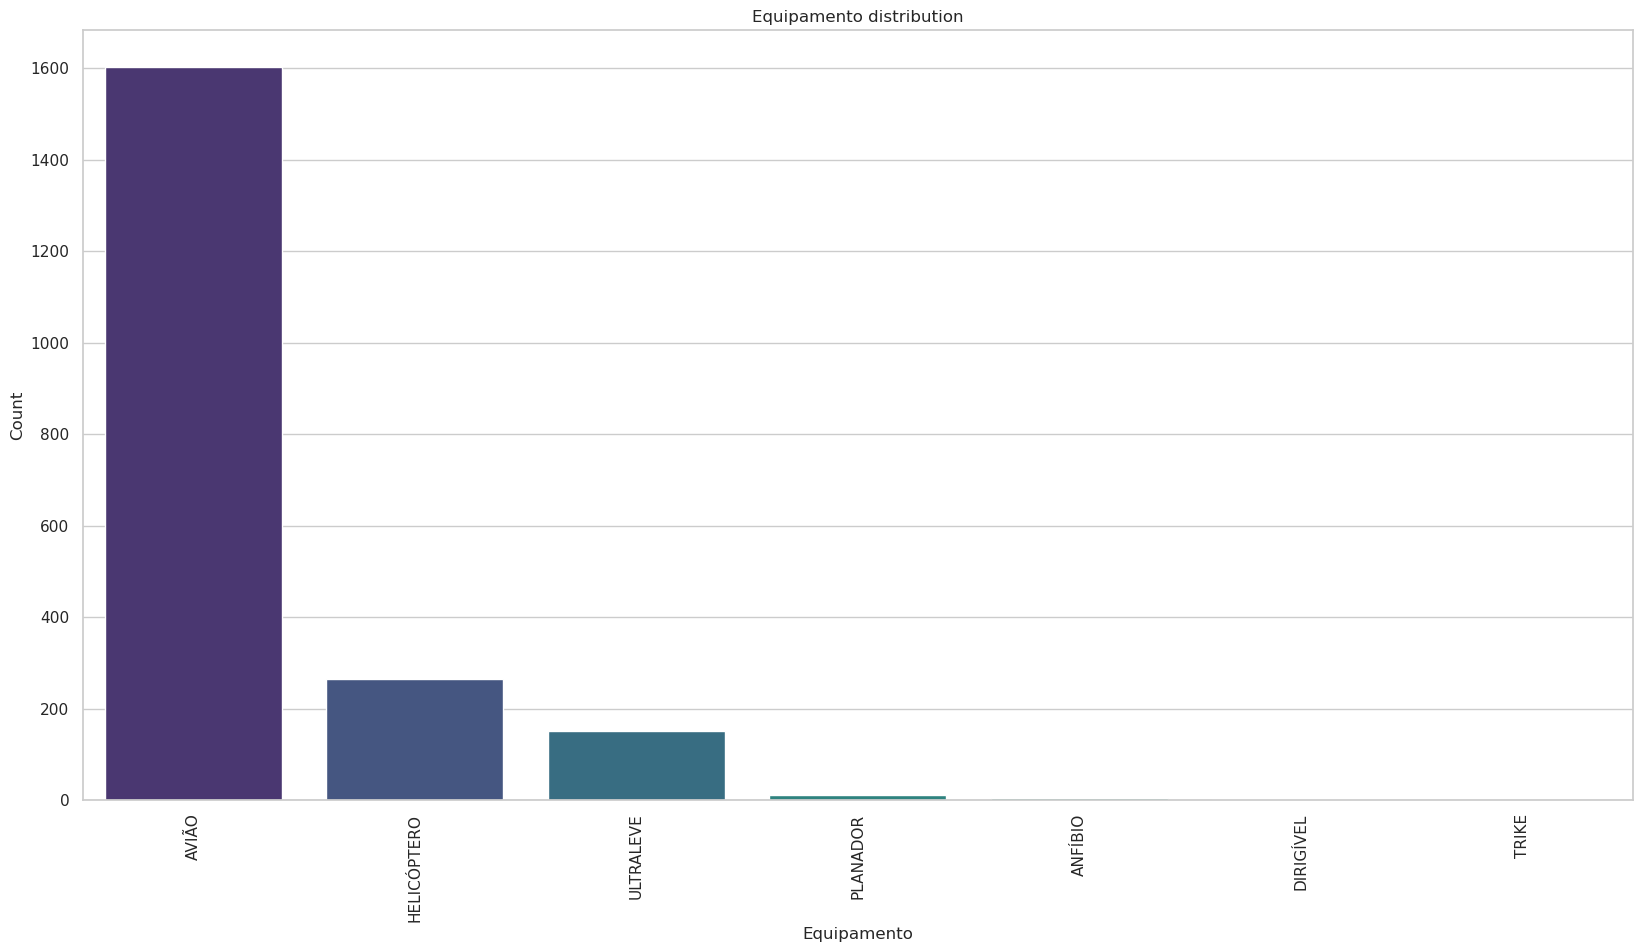

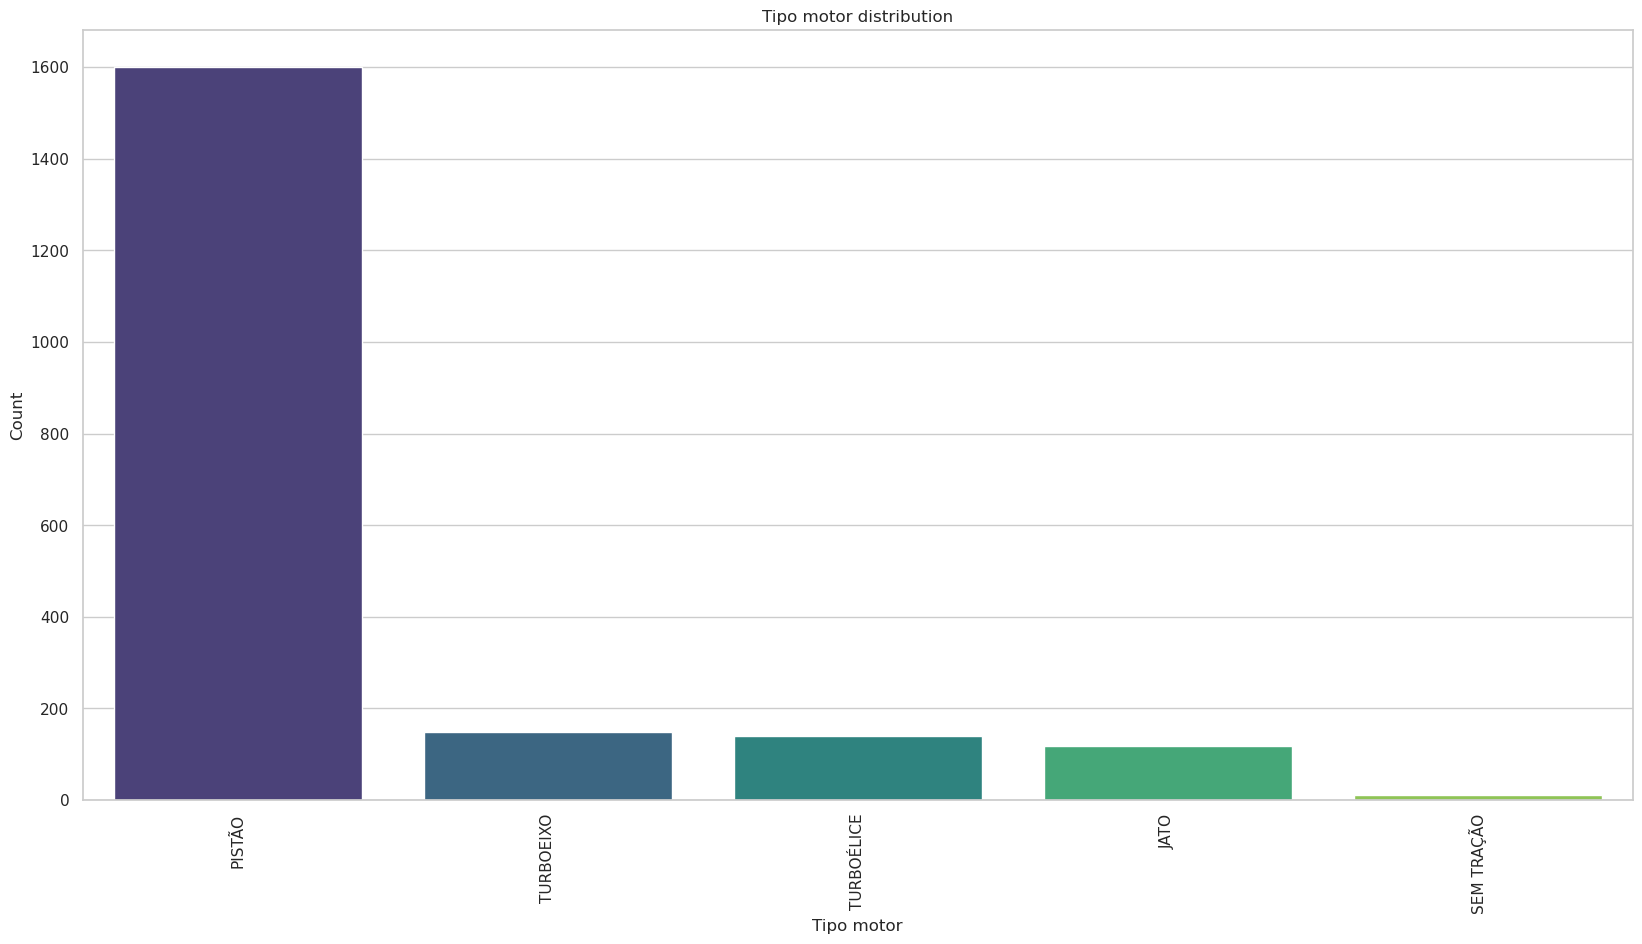

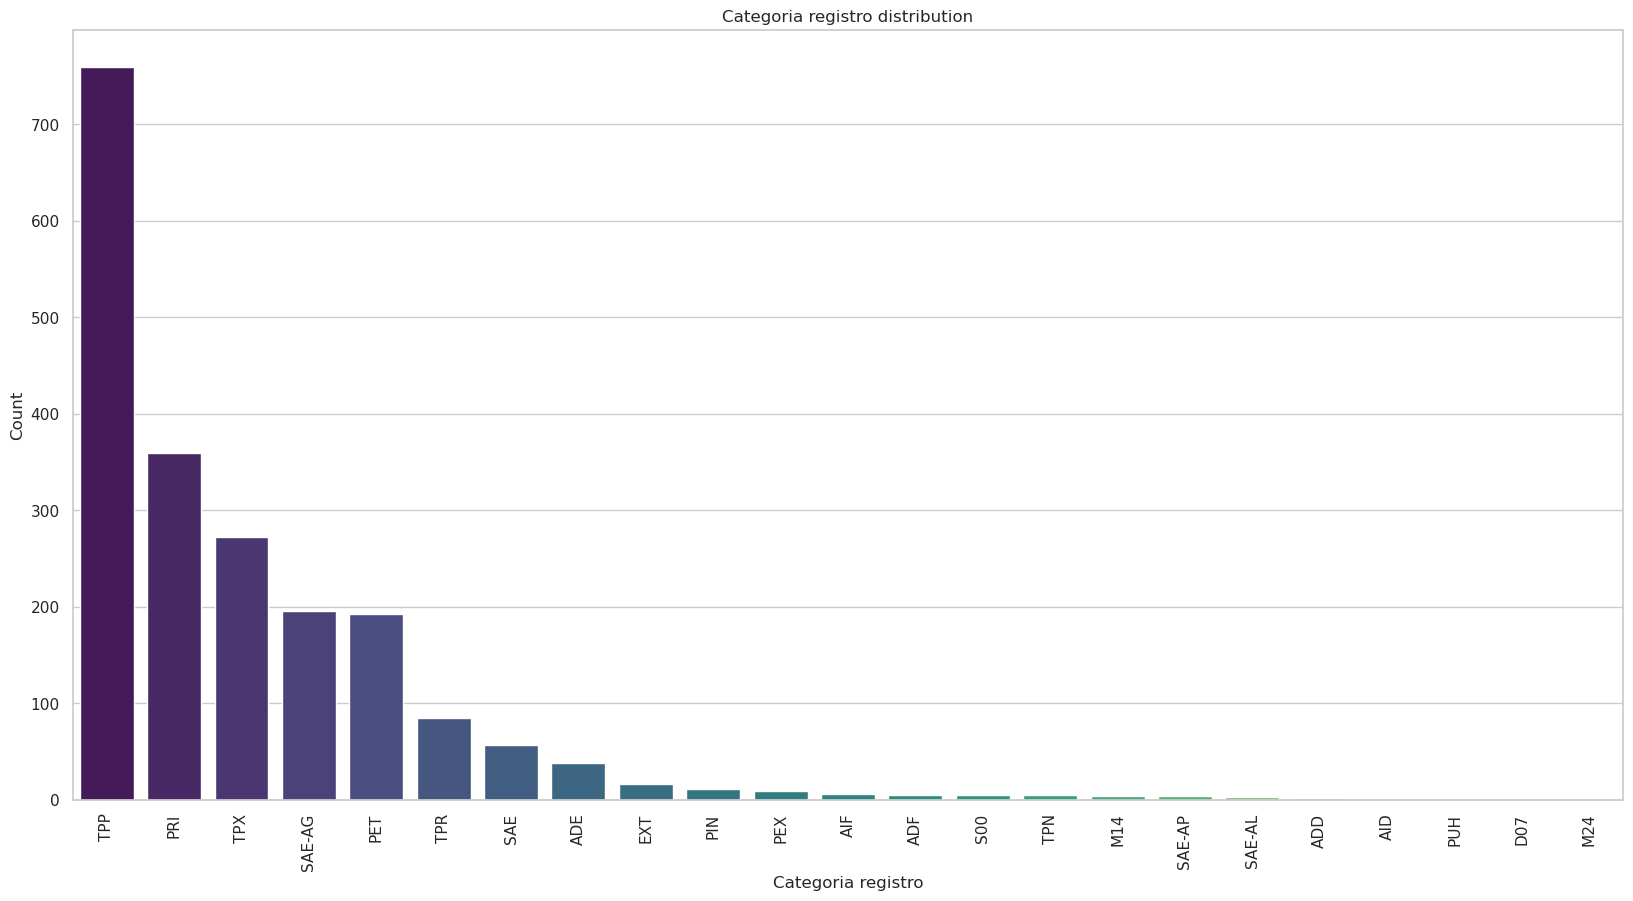

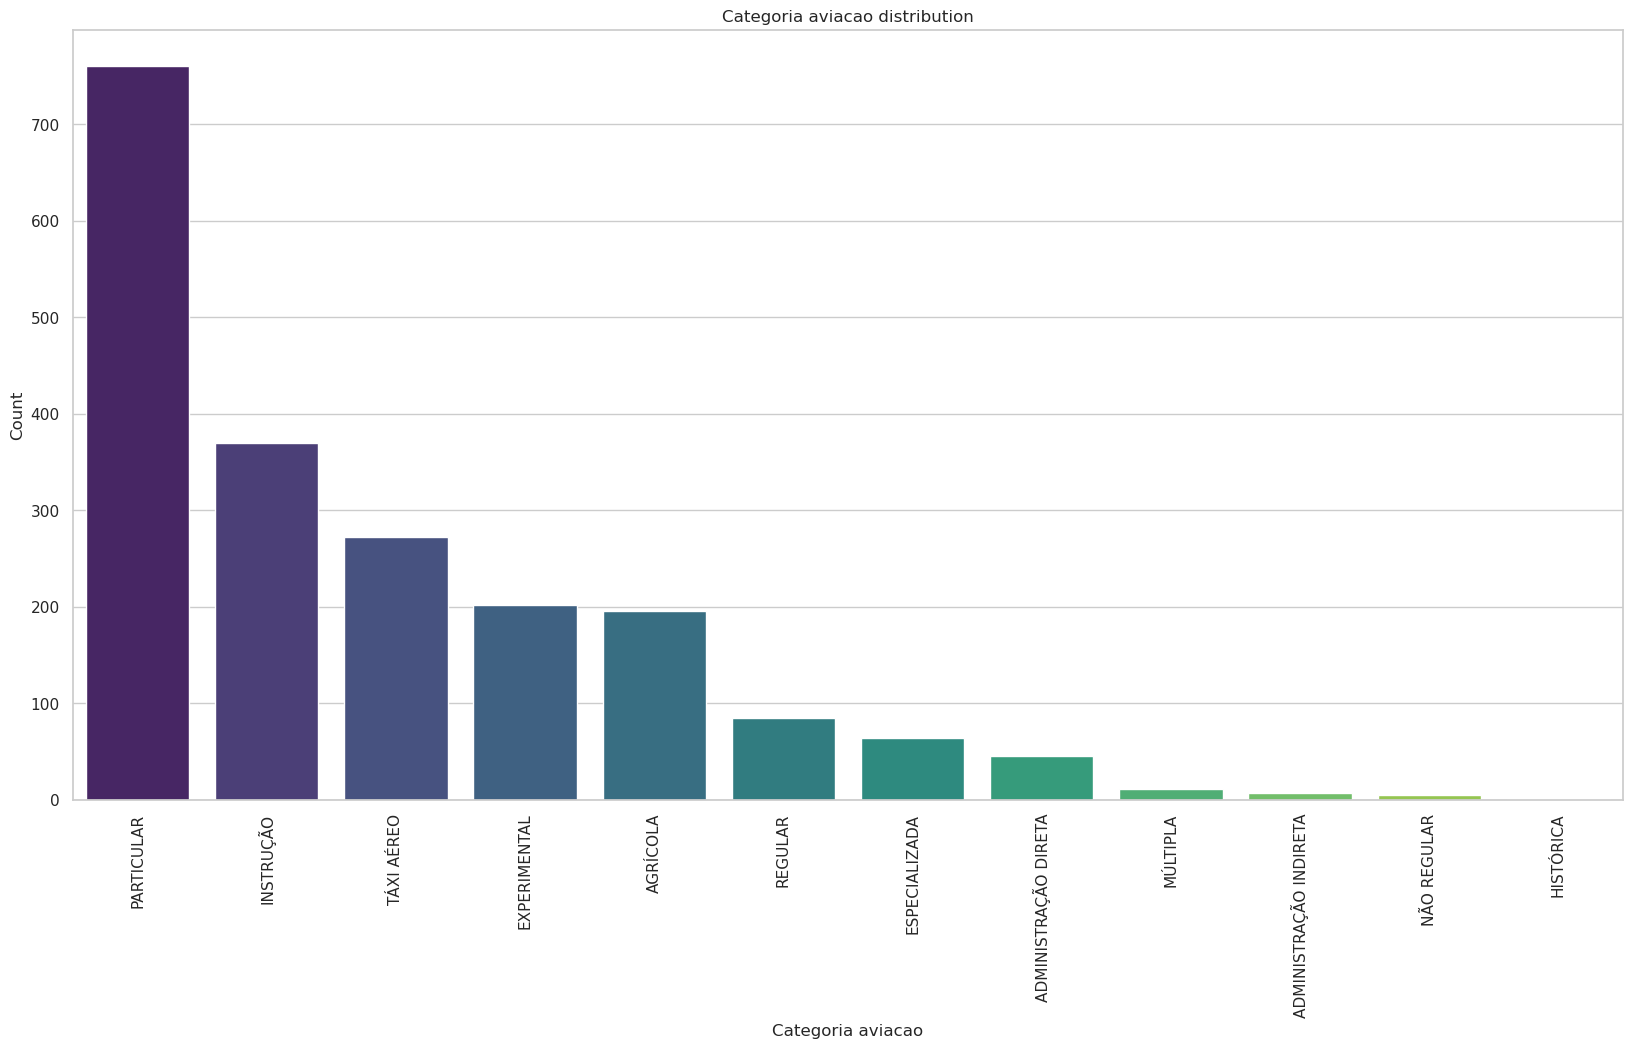

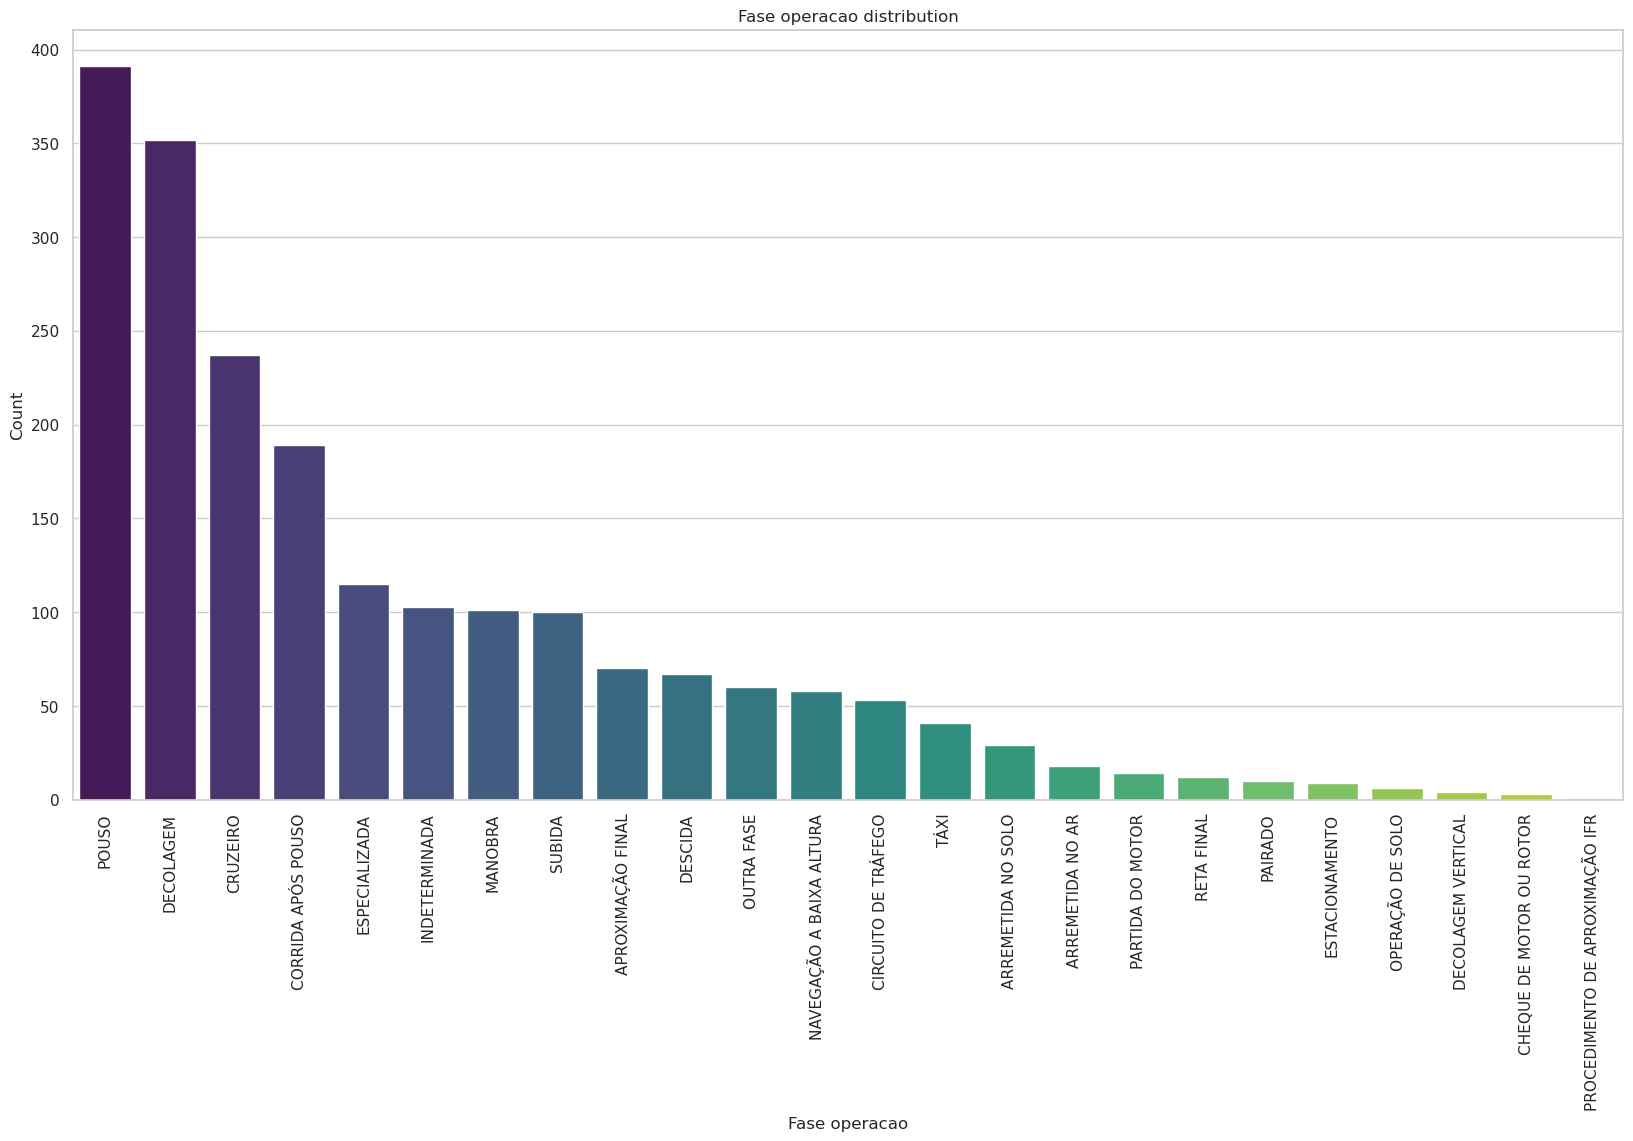

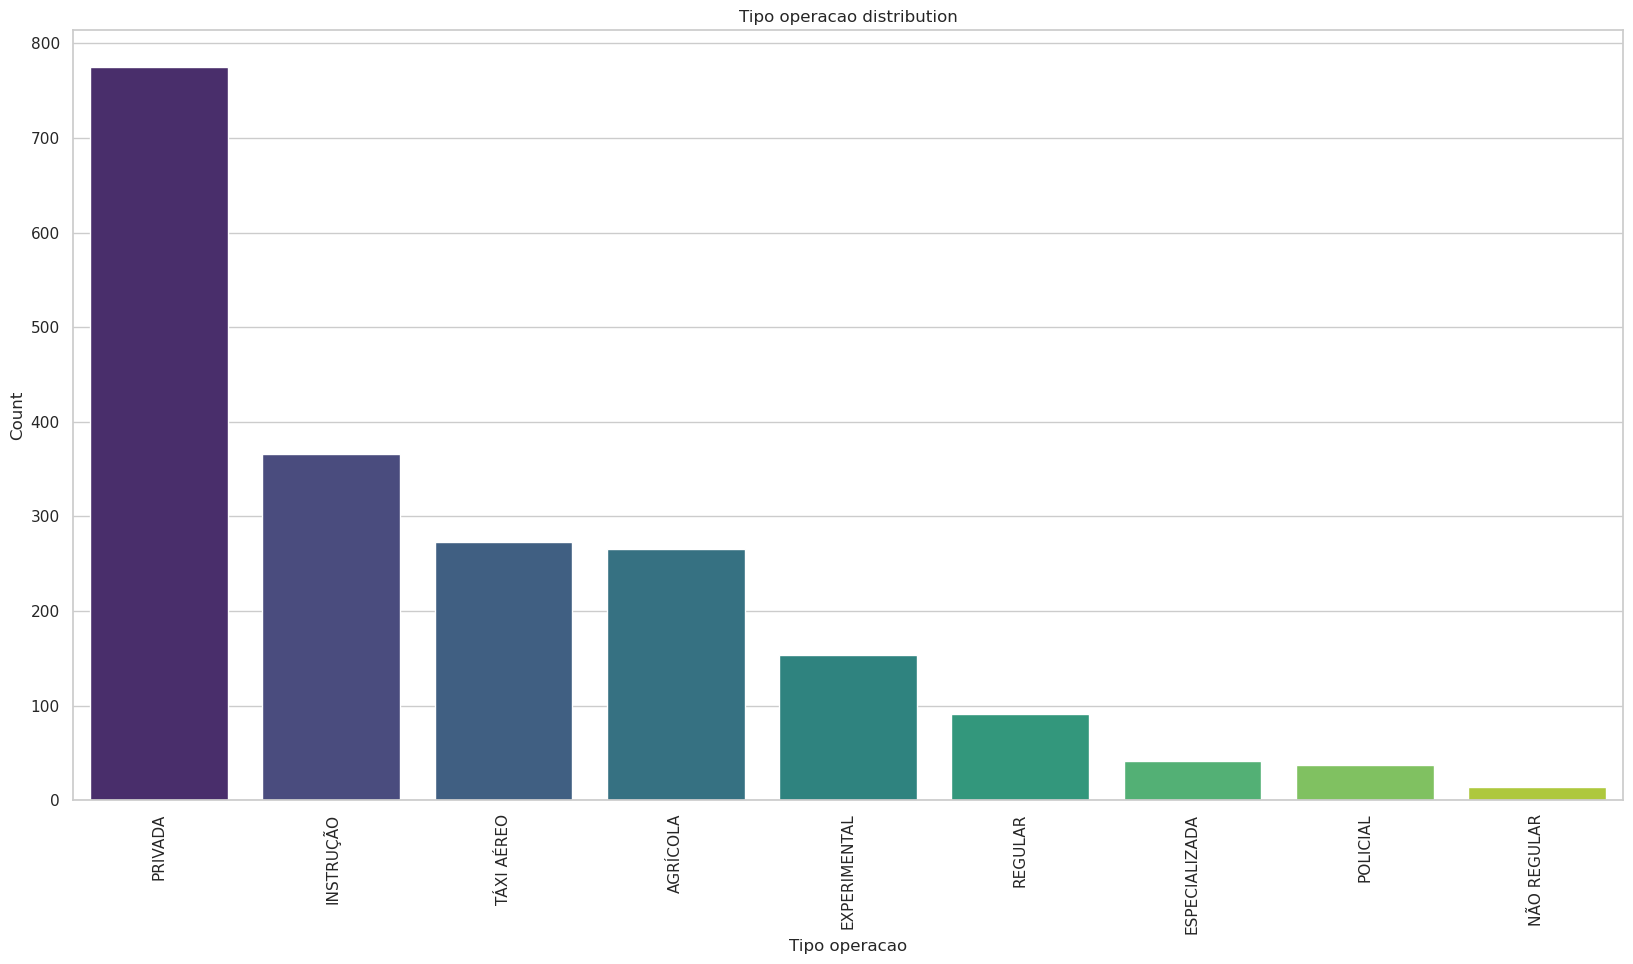

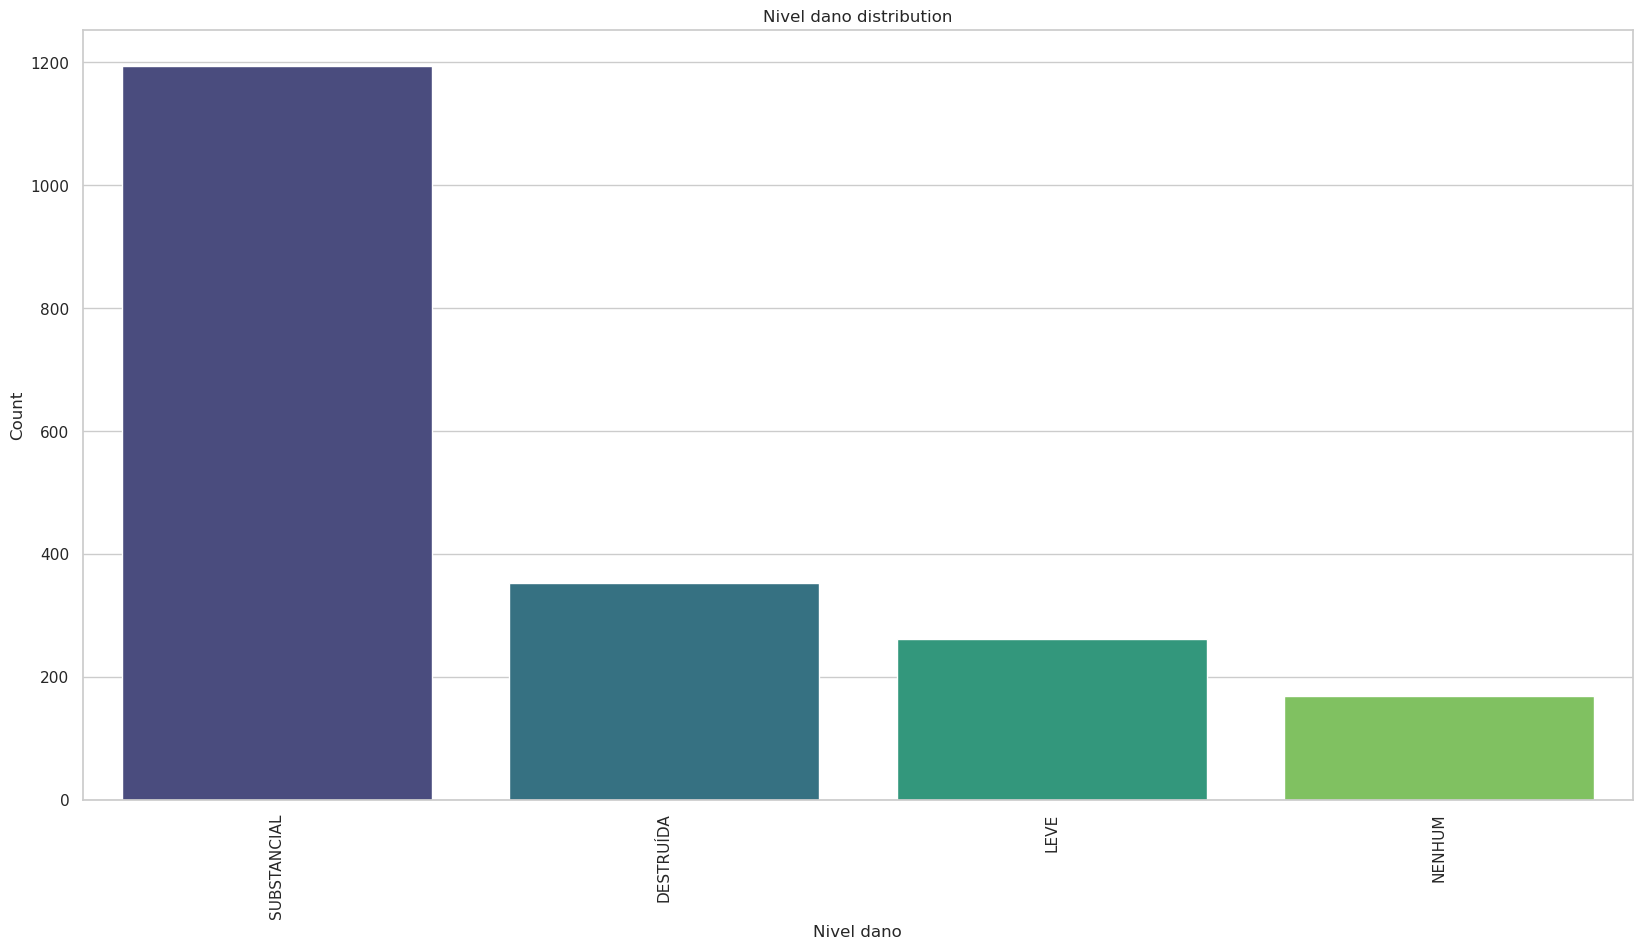

In [16]:
for col in ['equipamento', 'tipo_motor', 'categoria_registro', 'categoria_aviacao', 'fase_operacao', 'tipo_operacao', 'nivel_dano']:
    plt.figure(figsize=(20, 10))
    sns.countplot(data=aircraft_df, x=col, order=aircraft_df[col].value_counts().index, palette='viridis')
    plt.title(f'{col.replace("_", " ").capitalize()} distribution')
    plt.xlabel(f'{col.replace("_", " ").capitalize()}')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

From this simple data characterization we can infer that the majority of the occurrences are related to private aircrafts, more especifically, particular airplanes. These airplanes usually are substantially damaged and suffered the occurrence during the landing, followed by departure occurrences.

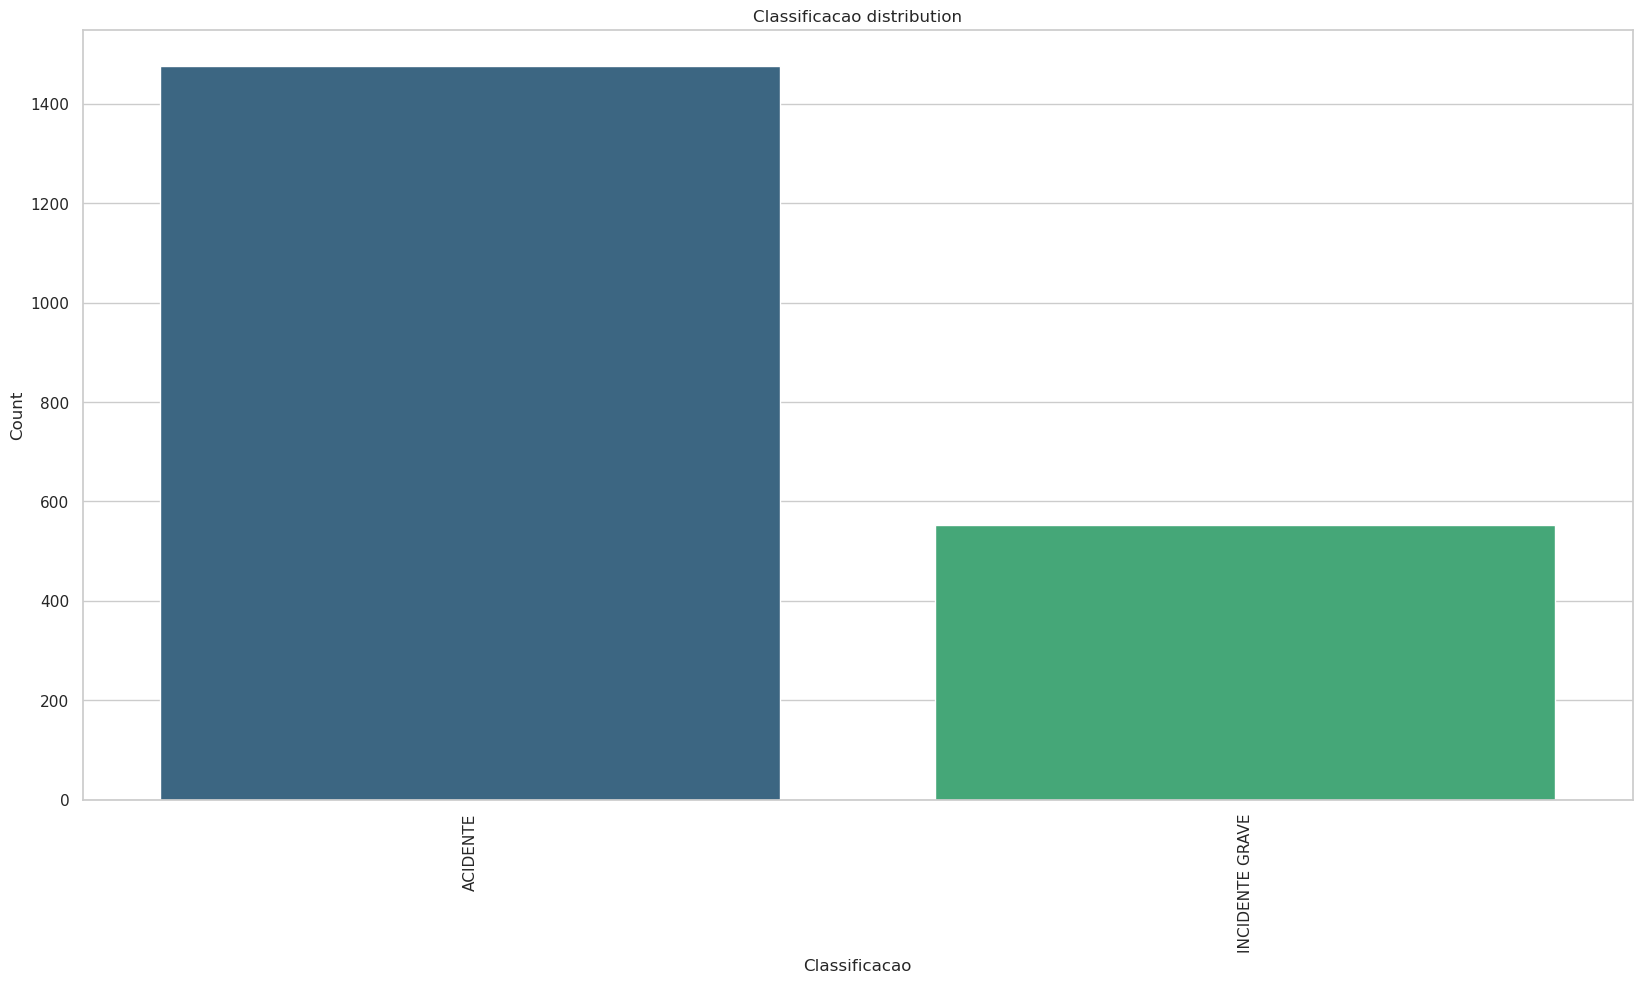

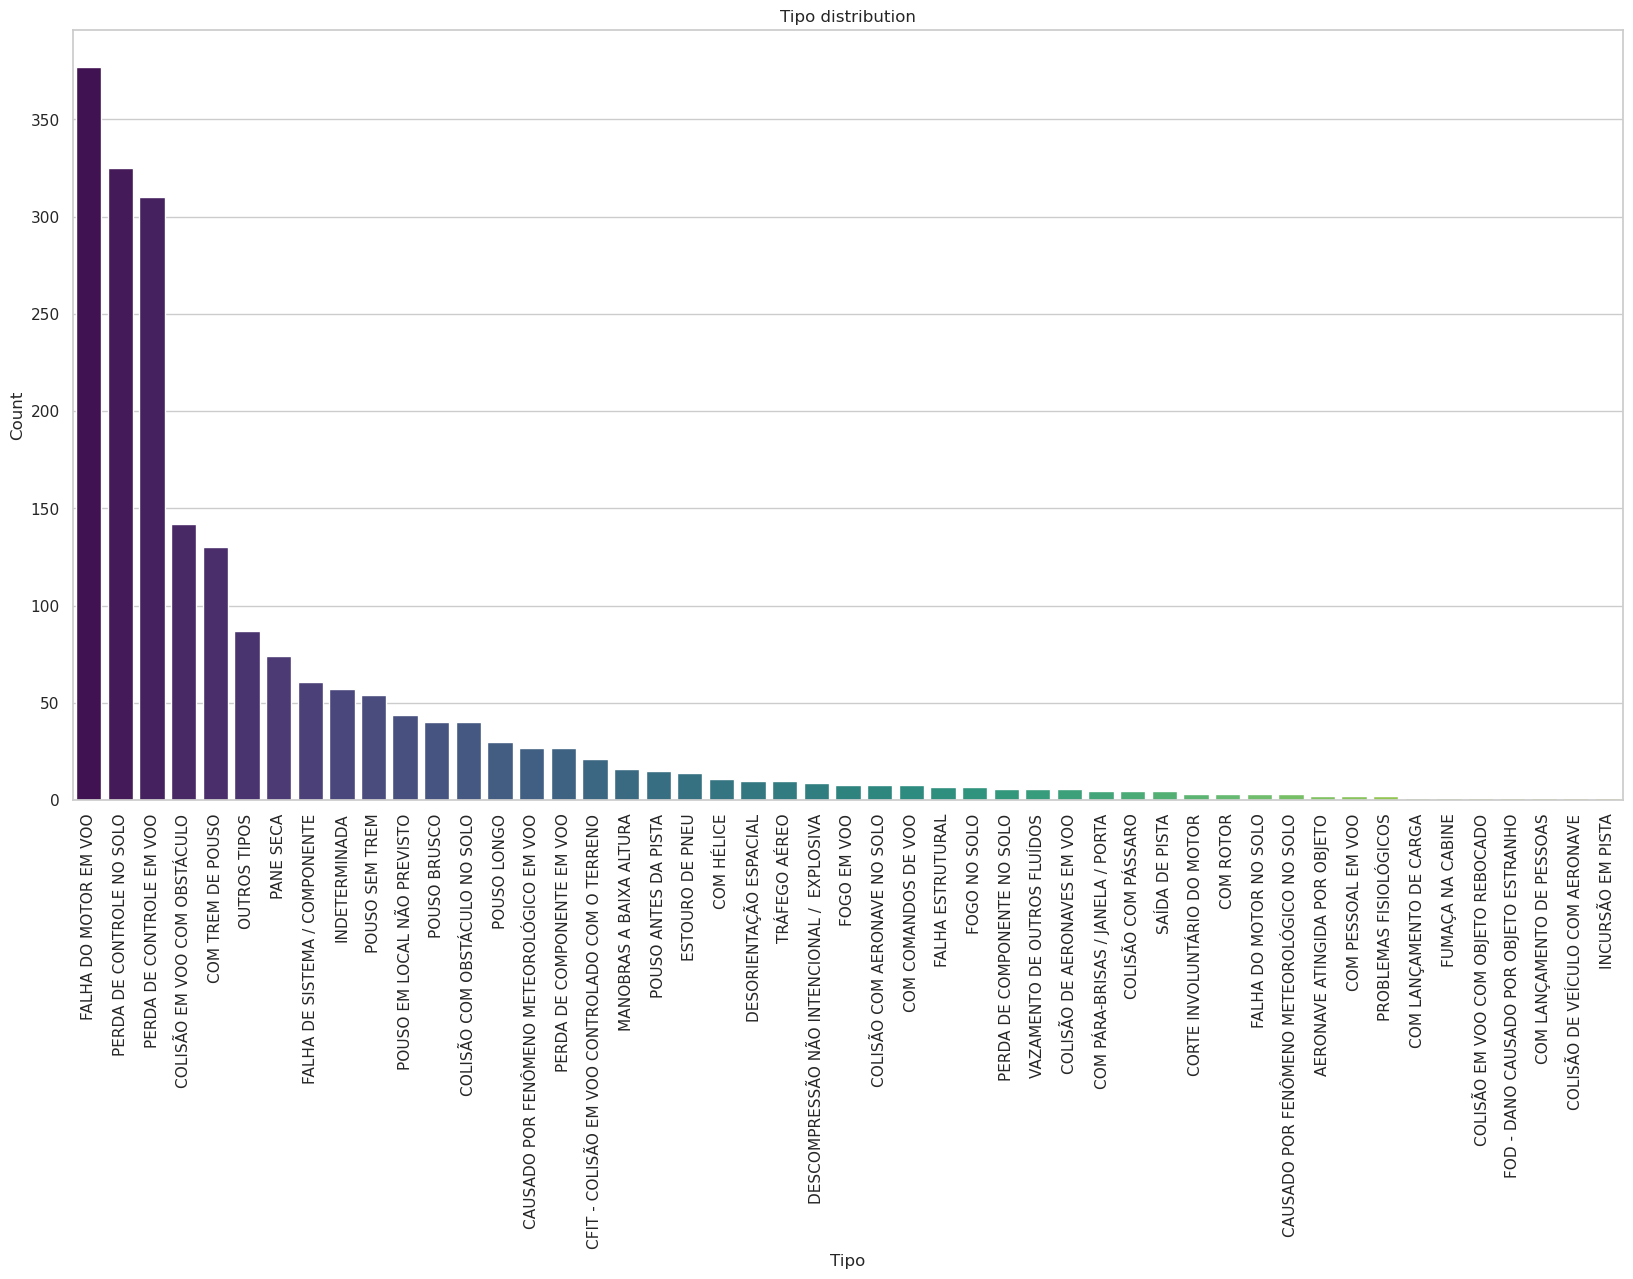

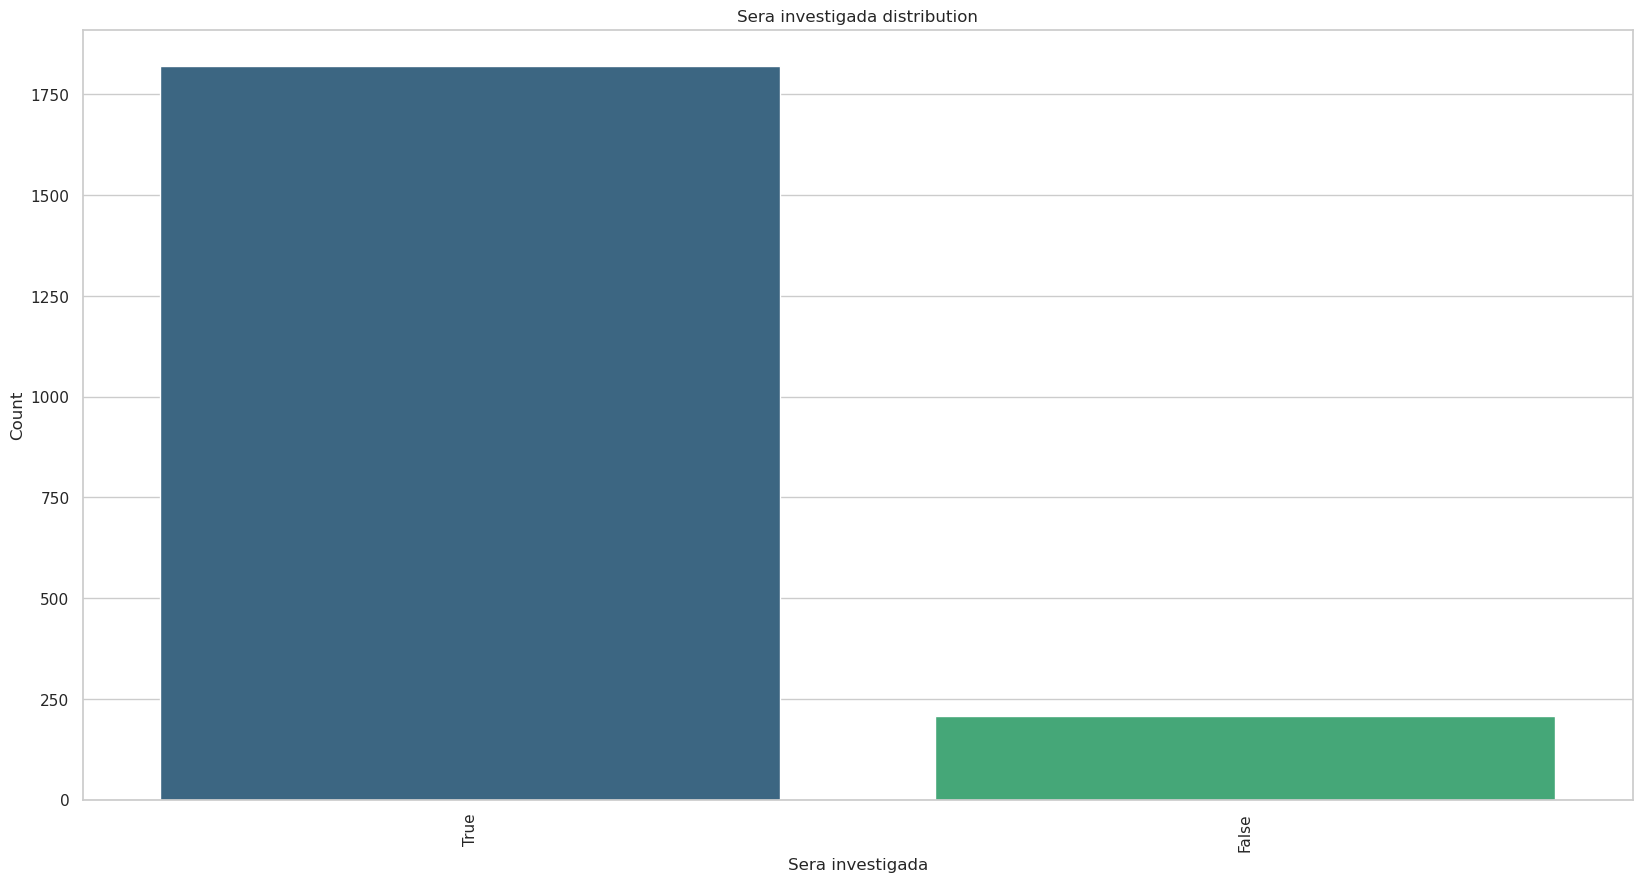

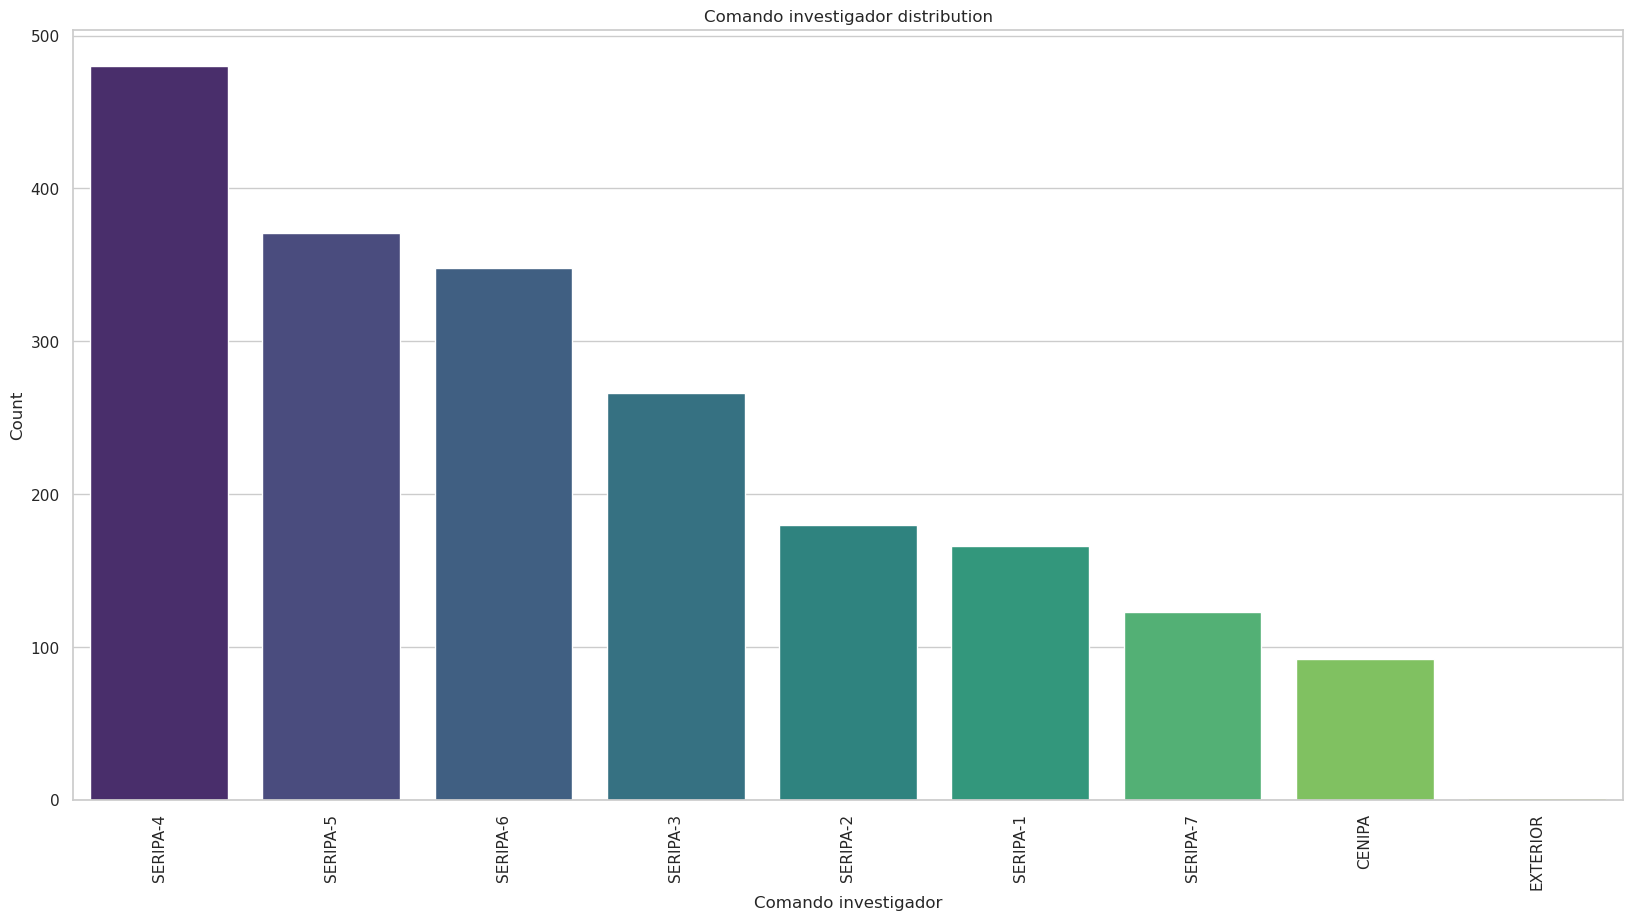

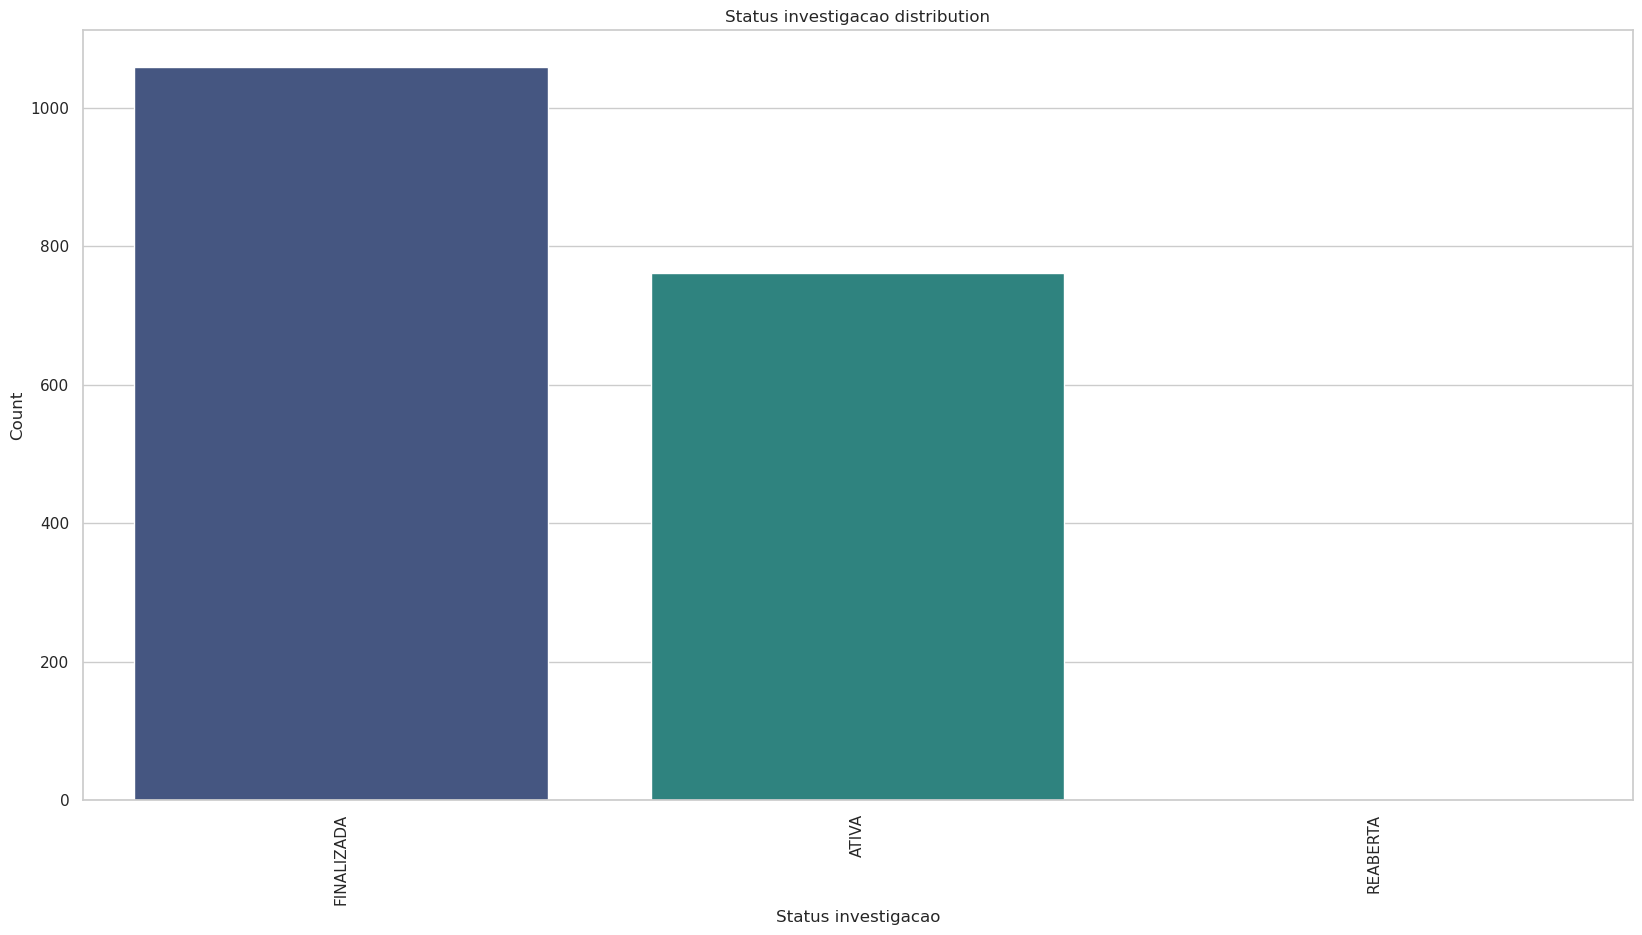

In [17]:
for col in ['classificacao', 'tipo', 'sera_investigada', 'comando_investigador', 'status_investigacao']:
    plt.figure(figsize=(20, 10))
    sns.countplot(data=occurrence_df, x=col, order=occurrence_df[col].value_counts().index, palette='viridis')
    plt.title(f'{col.replace("_", " ").capitalize()} distribution')
    plt.xlabel(f'{col.replace("_", " ").capitalize()}')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

Complemeting the aircraft table information, most of the occurrences are related to engine failure, resulting in an accident.

### Numerical data

In [18]:
print('Aircraft table numerical description')
display(aircraft_df[aircraft_numerical_columns].describe())

print('Occurrence table numerical description')
display(occurrence_df[occurrence_numerical_columns].describe())

Aircraft table numerical description


quantidade_motores  peso_maximo_decolagem  quantidade_assentos  \
count         2034.000000             2043.00000          2025.000000   
mean             1.244346             5329.94420             8.928889   
std              0.483653            22004.50988            26.922299   
min              0.000000                0.00000             0.000000   
25%              1.000000              844.00000             2.000000   
50%              1.000000             1633.00000             4.000000   
75%              2.000000             2155.00000             6.000000   
max              4.000000           285990.00000           301.000000   

       ano_fabricacao  quantidade_fatalidades  
count     2039.000000              355.000000  
mean      1902.494850                3.208451  
std        402.024605               13.367108  
min          0.000000                1.000000  
25%       1975.000000                1.000000  
50%       1986.000000                2.000000  
75%       1999.000000                2.000000  
max       2015.000000              199.000000

Occurrence table numerical description


quantidade_recomendacoes  aeronaves_envolvidas
count               2027.000000           2027.000000
mean                   1.141095              1.007893
std                    3.571001              0.103906
min                    0.000000              1.000000
25%                    0.000000              1.000000
50%                    0.000000              1.000000
75%                    1.000000              1.000000
max                   83.000000              4.000000

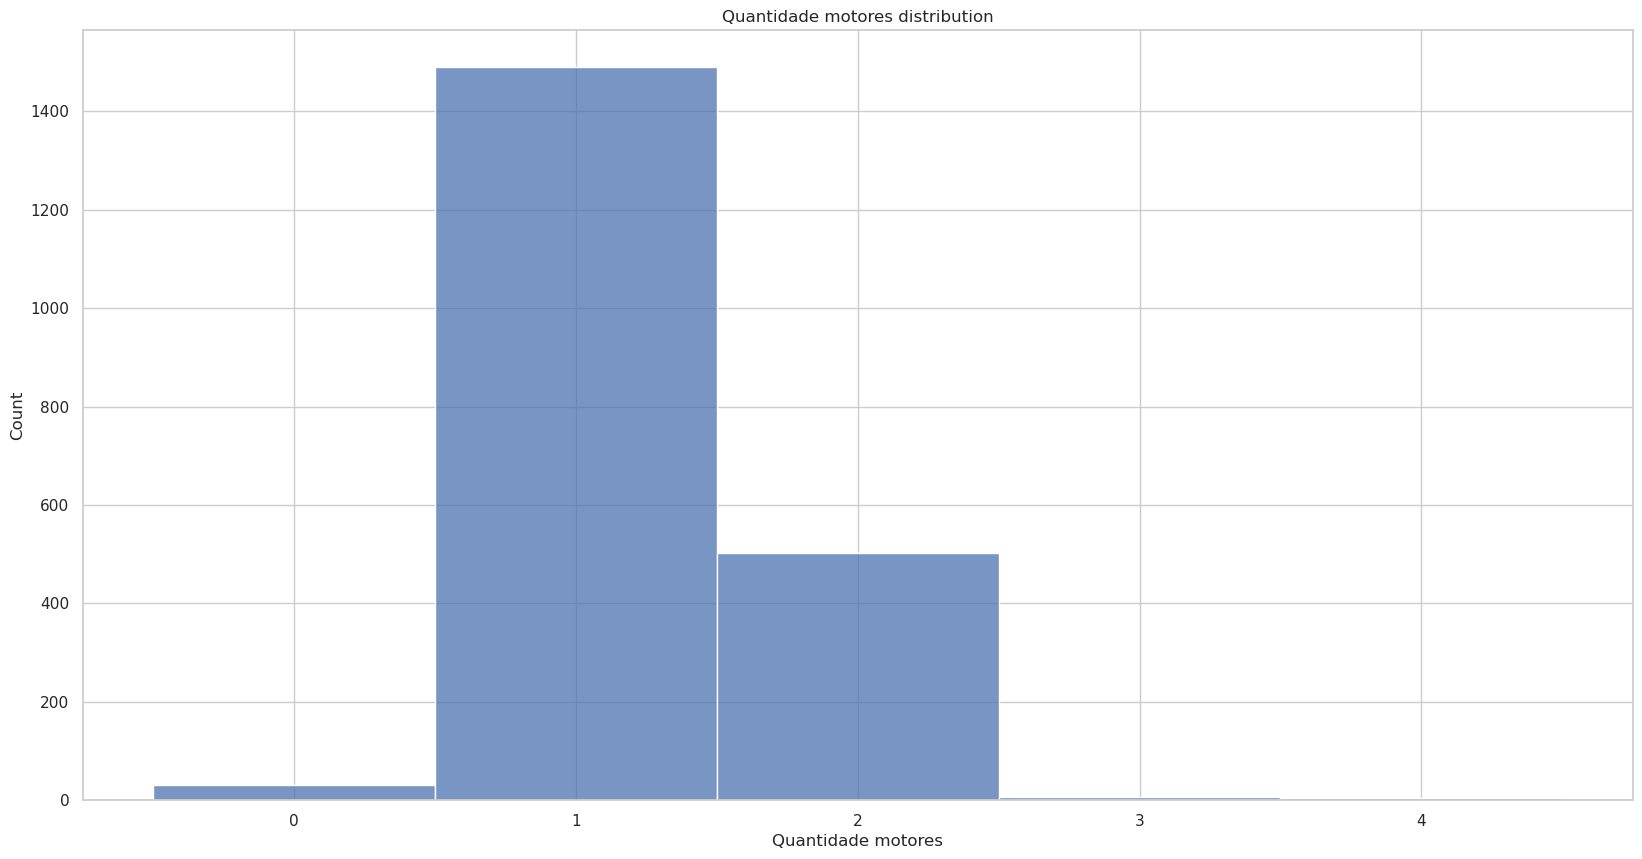

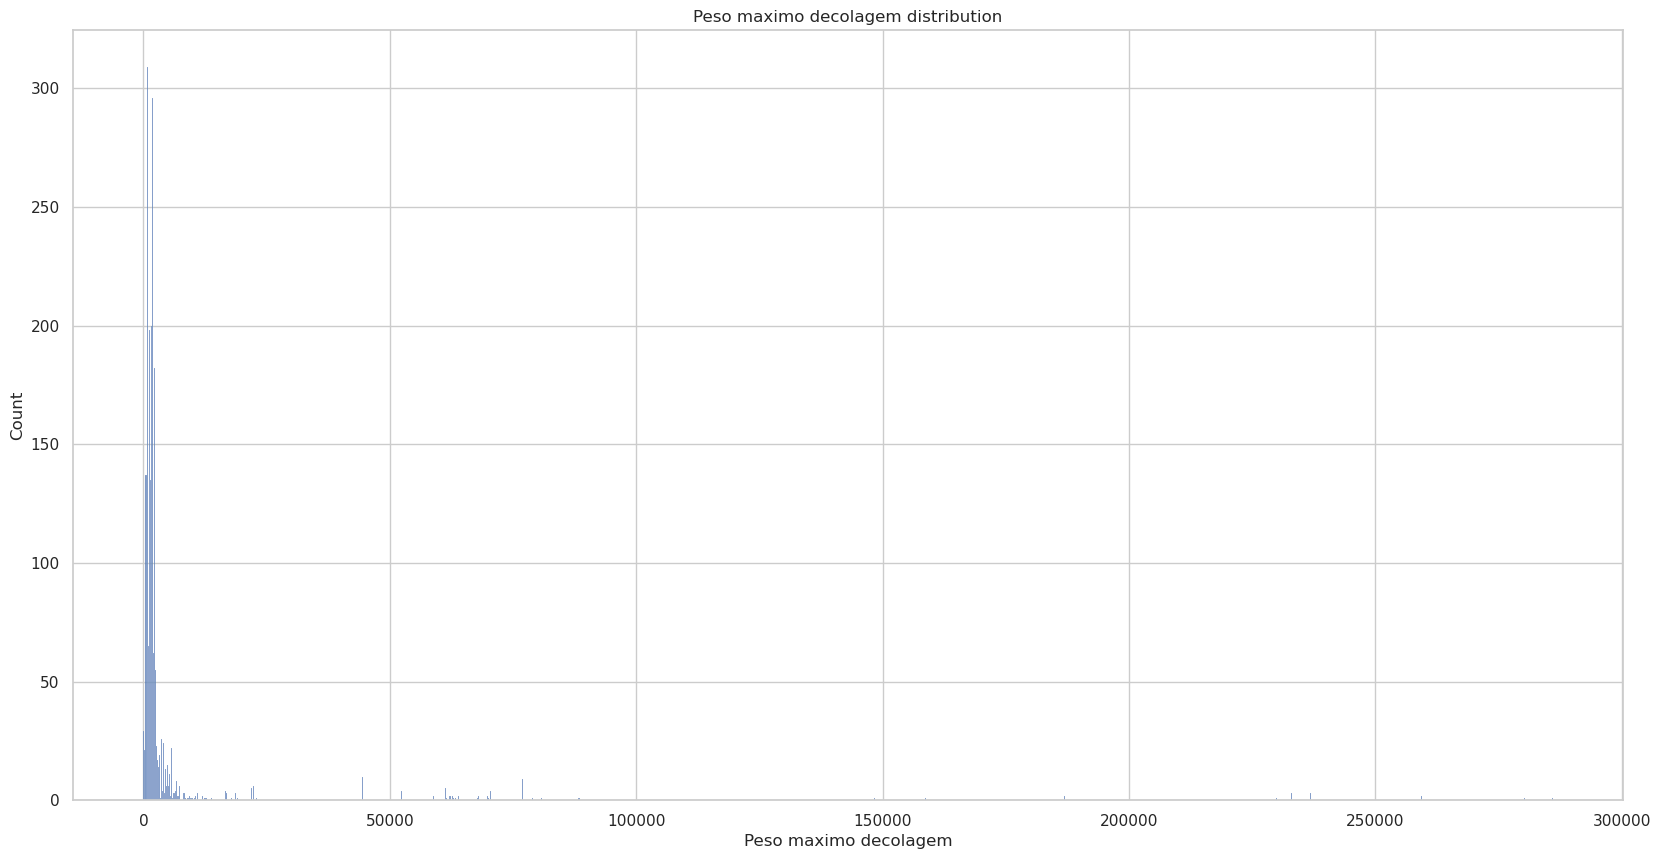

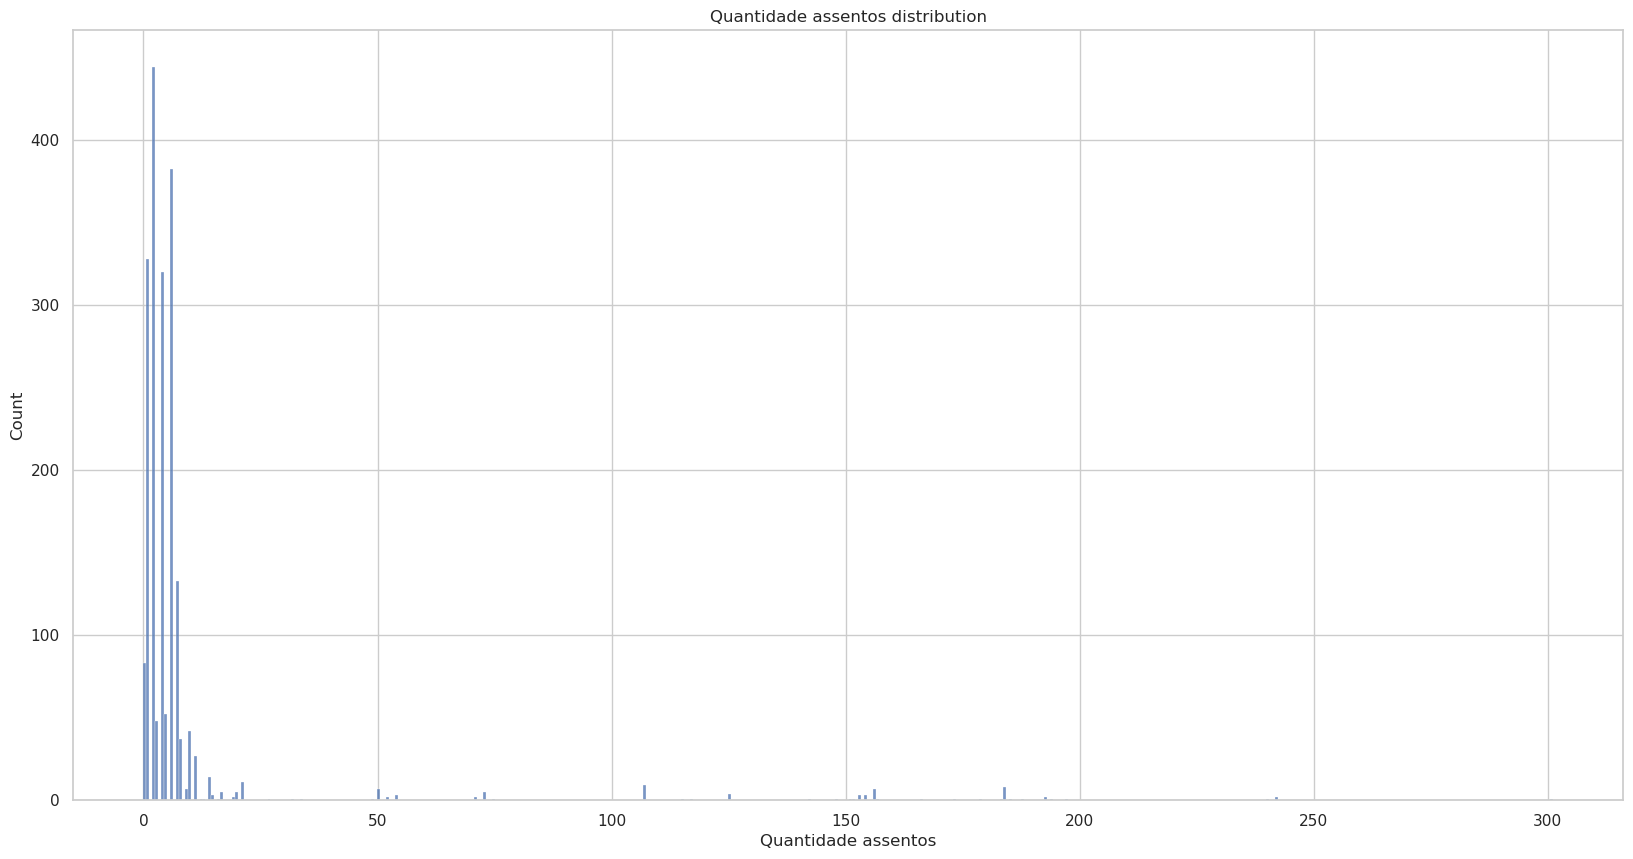

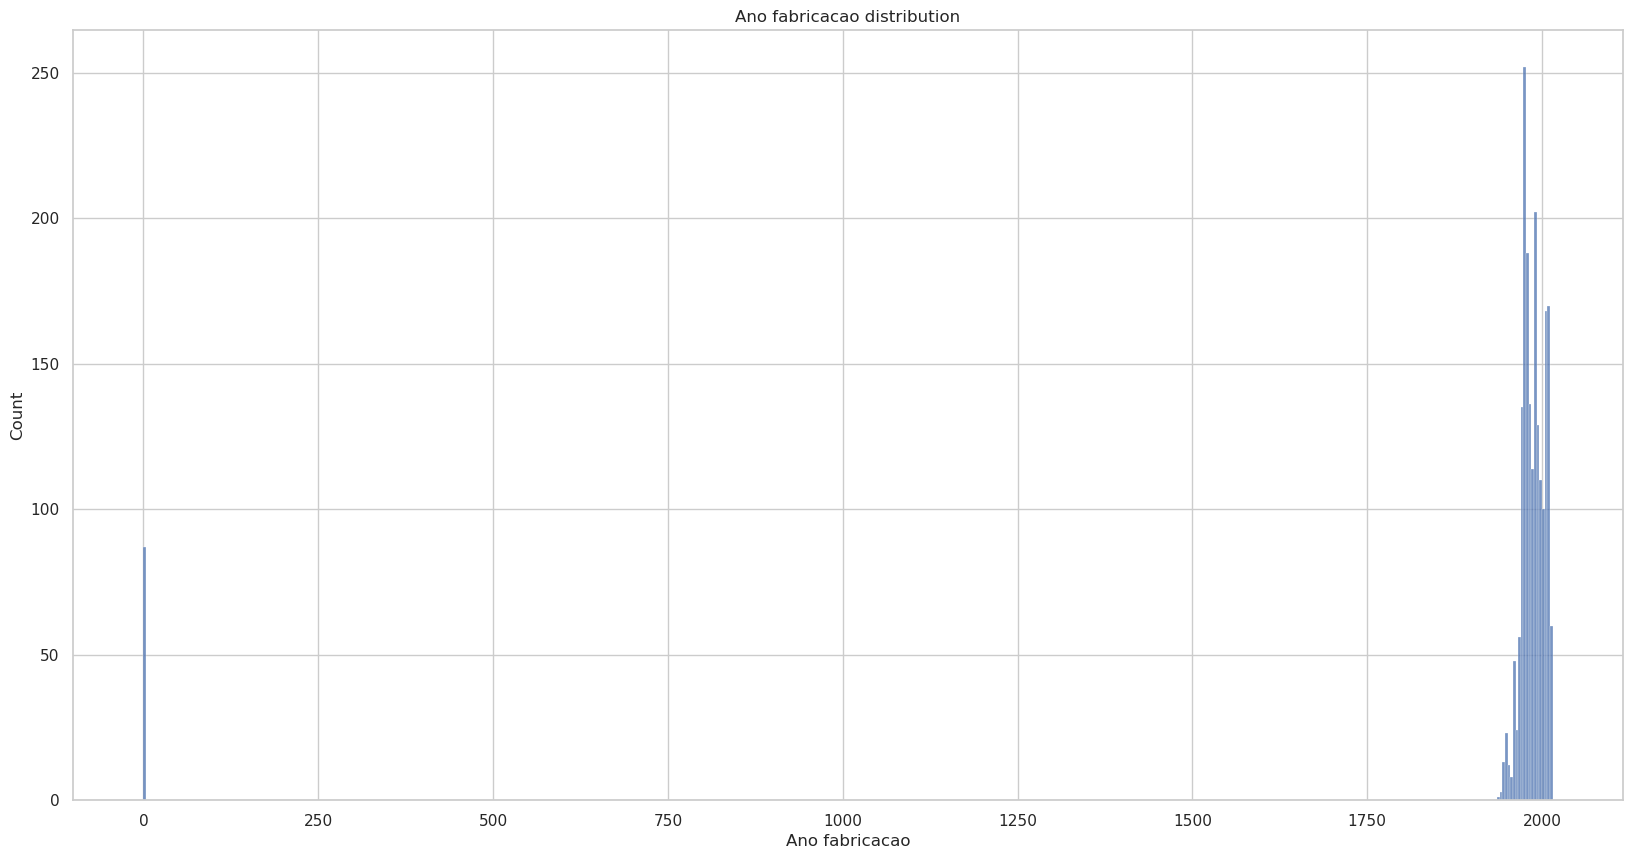

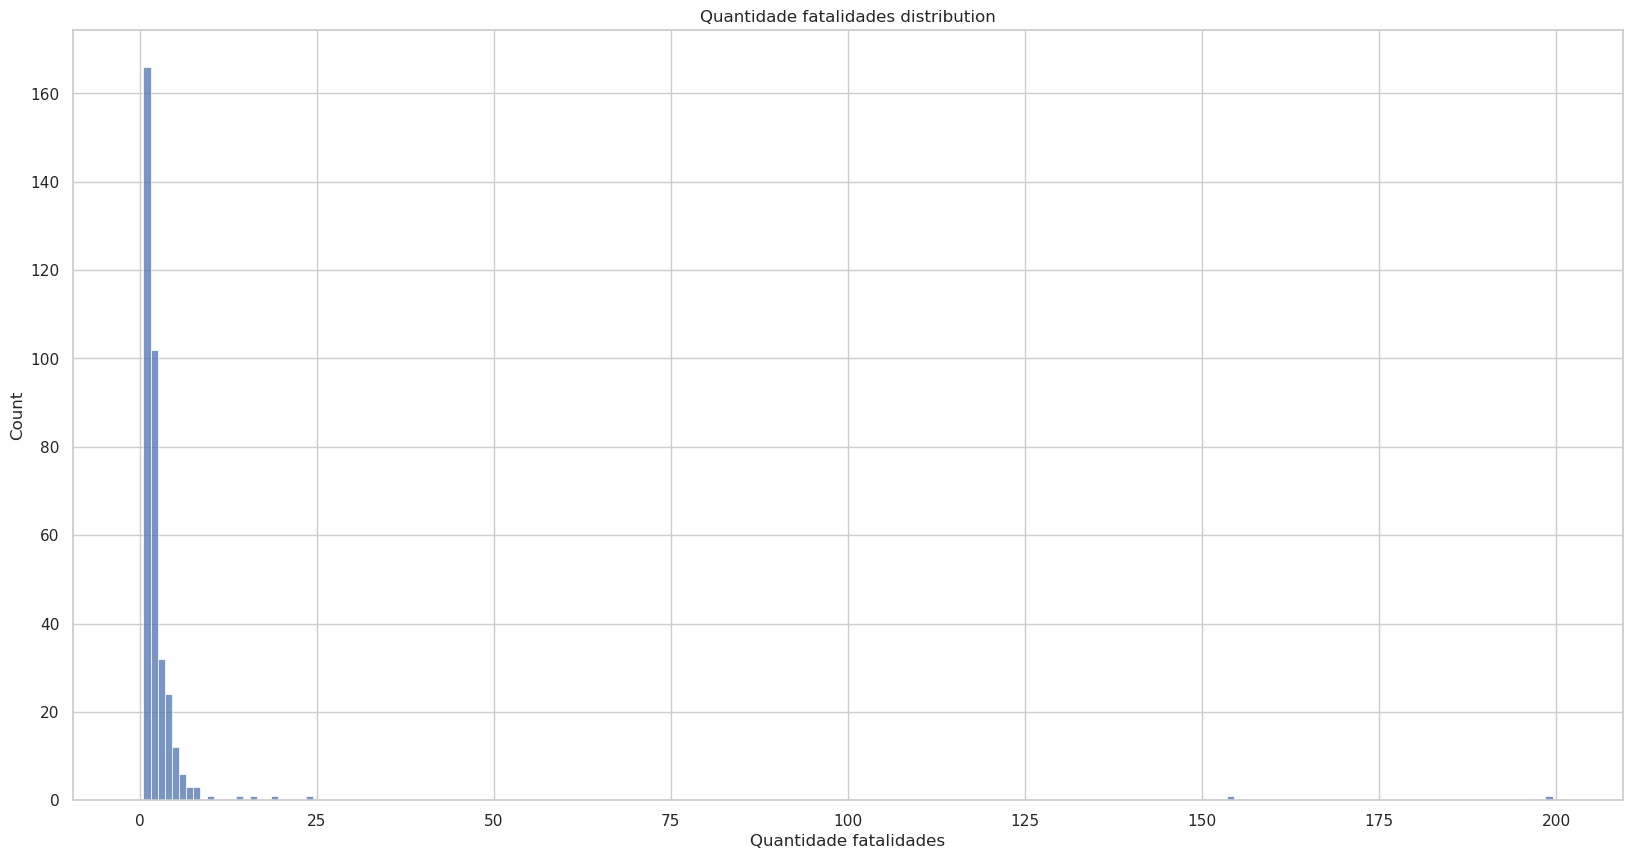

In [19]:
for col in aircraft_numerical_columns:
    plt.figure(figsize=(20, 10))
    sns.histplot(data=aircraft_df, x=col, discrete=(aircraft_df[col].nunique() < 20))
    plt.title(f'{col.replace("_", " ").capitalize()} distribution')
    plt.xlabel(f'{col.replace("_", " ").capitalize()}')
    plt.ylabel('Count')
    plt.show()

As expected, the mono-engine aircrafts are the ones with most occurrences. This is expected due to the redundancy lack in this aircraft. As we observed early in the categorical data characterization, the majority of the occurrences registered are related to engine failure.

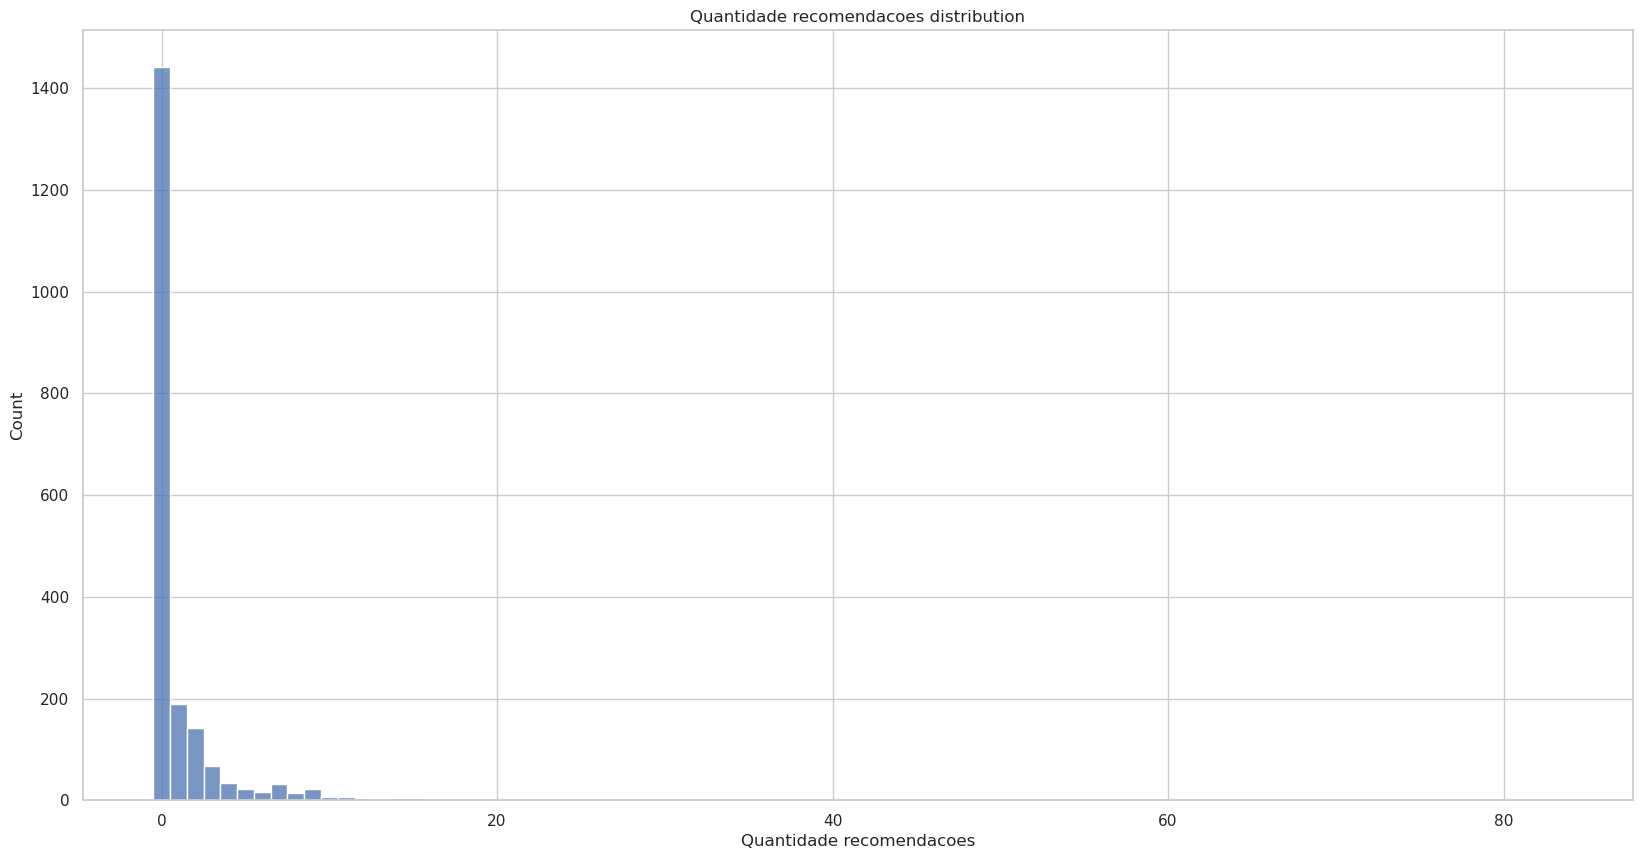

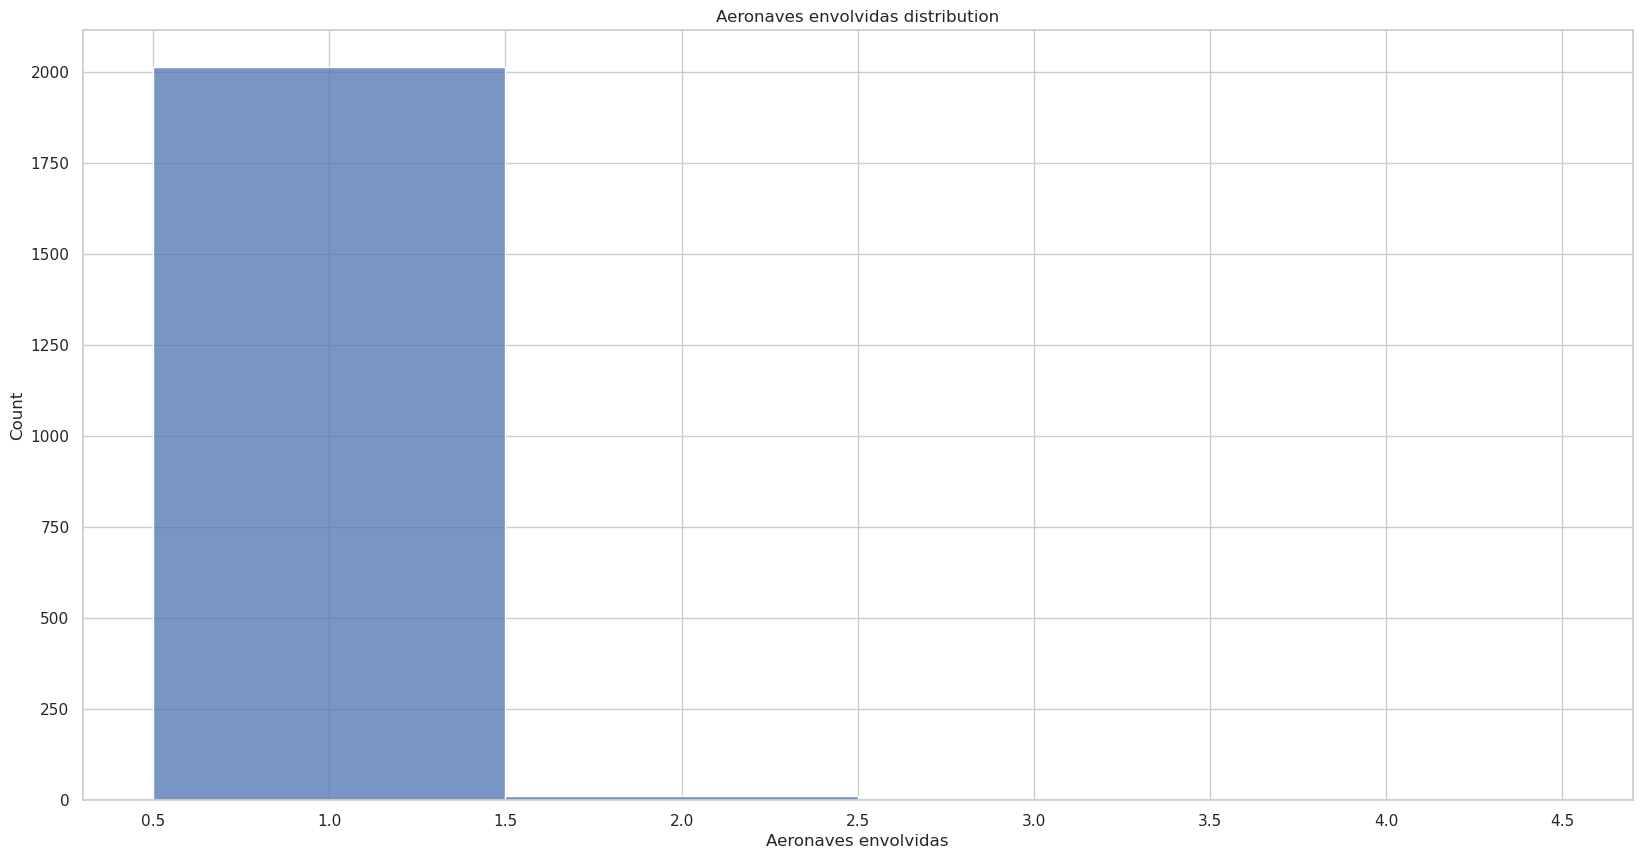

In [20]:
for col in occurrence_numerical_columns:
    plt.figure(figsize=(20, 10))
    sns.histplot(data=occurrence_df, x=col, discrete=True)
    plt.title(f'{col.replace("_", " ").capitalize()} distribution')
    plt.xlabel(f'{col.replace("_", " ").capitalize()}')
    plt.ylabel('Count')
    plt.show()

### Datetime data

In [21]:
# Get total period of time
print('Aircraft table datetime description')
print(f'Total period of time for `dia_extracao`: {aircraft_df["dia_extracao"].max() - aircraft_df["dia_extracao"].min()}')
print('')
print('Occurrence table datetime description')
print(f'Total period of time for `dia_ocorrencia`: {occurrence_df["dia_ocorrencia"].max() - occurrence_df["dia_ocorrencia"].min()}')
print(f'Total period of time for `dia_publicacao`: {occurrence_df["dia_publicacao"].max() - occurrence_df["dia_publicacao"].min()}')
print(f'Total period of time for `dia_extracao`: {occurrence_df["dia_extracao"].max() - occurrence_df["dia_extracao"].min()}')


Aircraft table datetime description
Total period of time for `dia_extracao`: 0 days 00:00:00

Occurrence table datetime description
Total period of time for `dia_ocorrencia`: 3650 days 00:00:00
Total period of time for `dia_publicacao`: 3574 days 00:00:00
Total period of time for `dia_extracao`: 0 days 00:00:00


As we can observe, the data extraction day for both tables were the same. The database was filled in all at once. Thus, there's no meaningful analysis to be done regarding this column (e.g. the delay time between the occurrence and the database update).

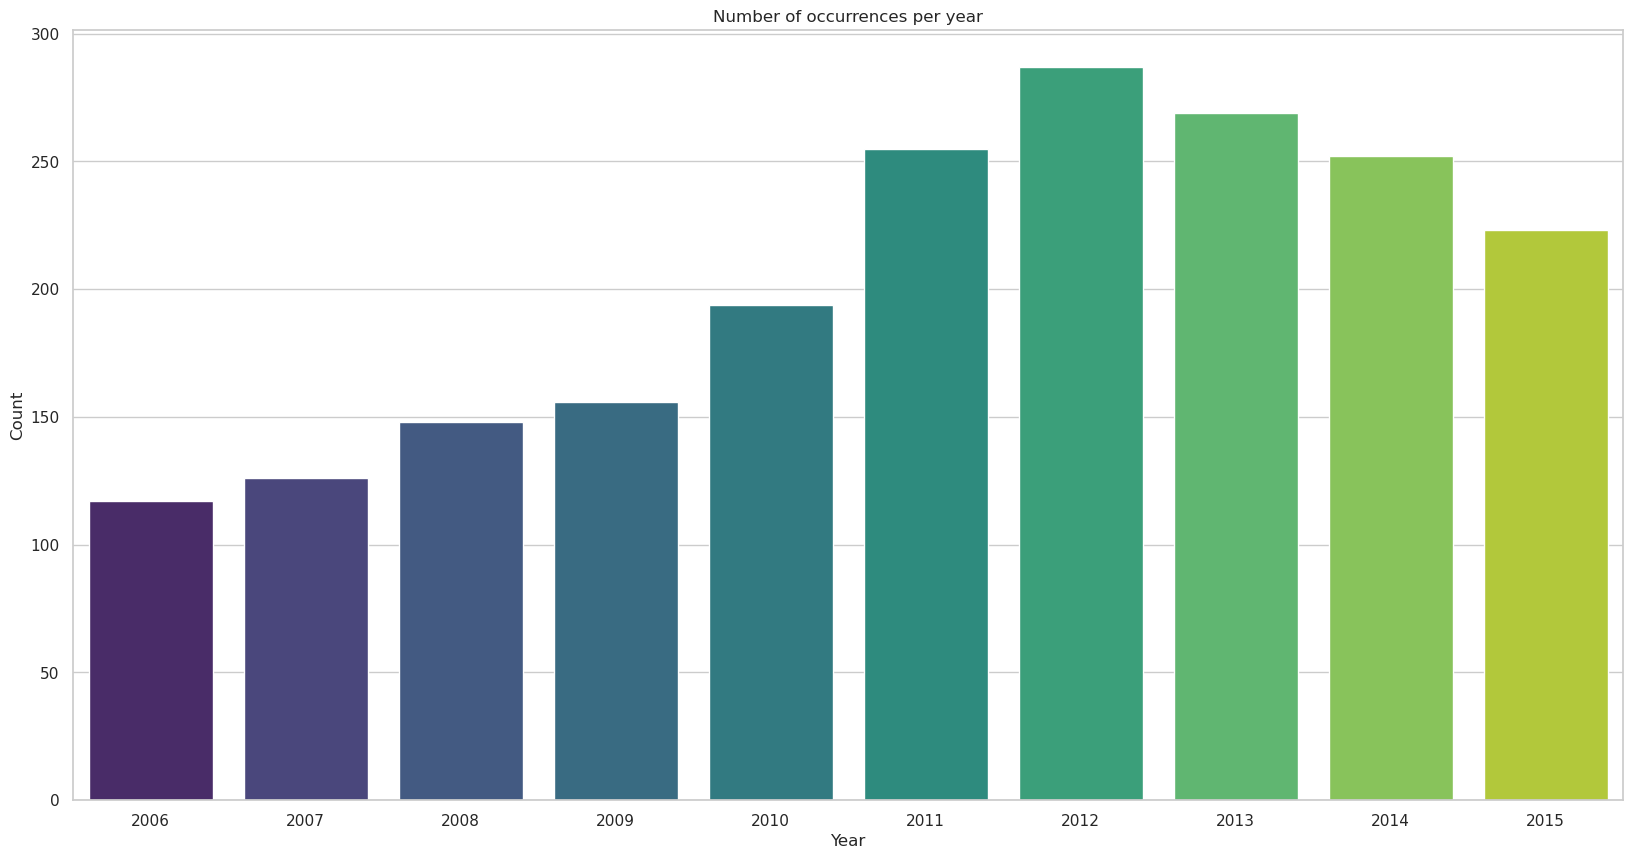

In [22]:
plt.figure(figsize=(20, 10))
sns.countplot(data=occurrence_df, x=occurrence_df['dia_ocorrencia'].dt.year, palette='viridis')
plt.title('Number of occurrences per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

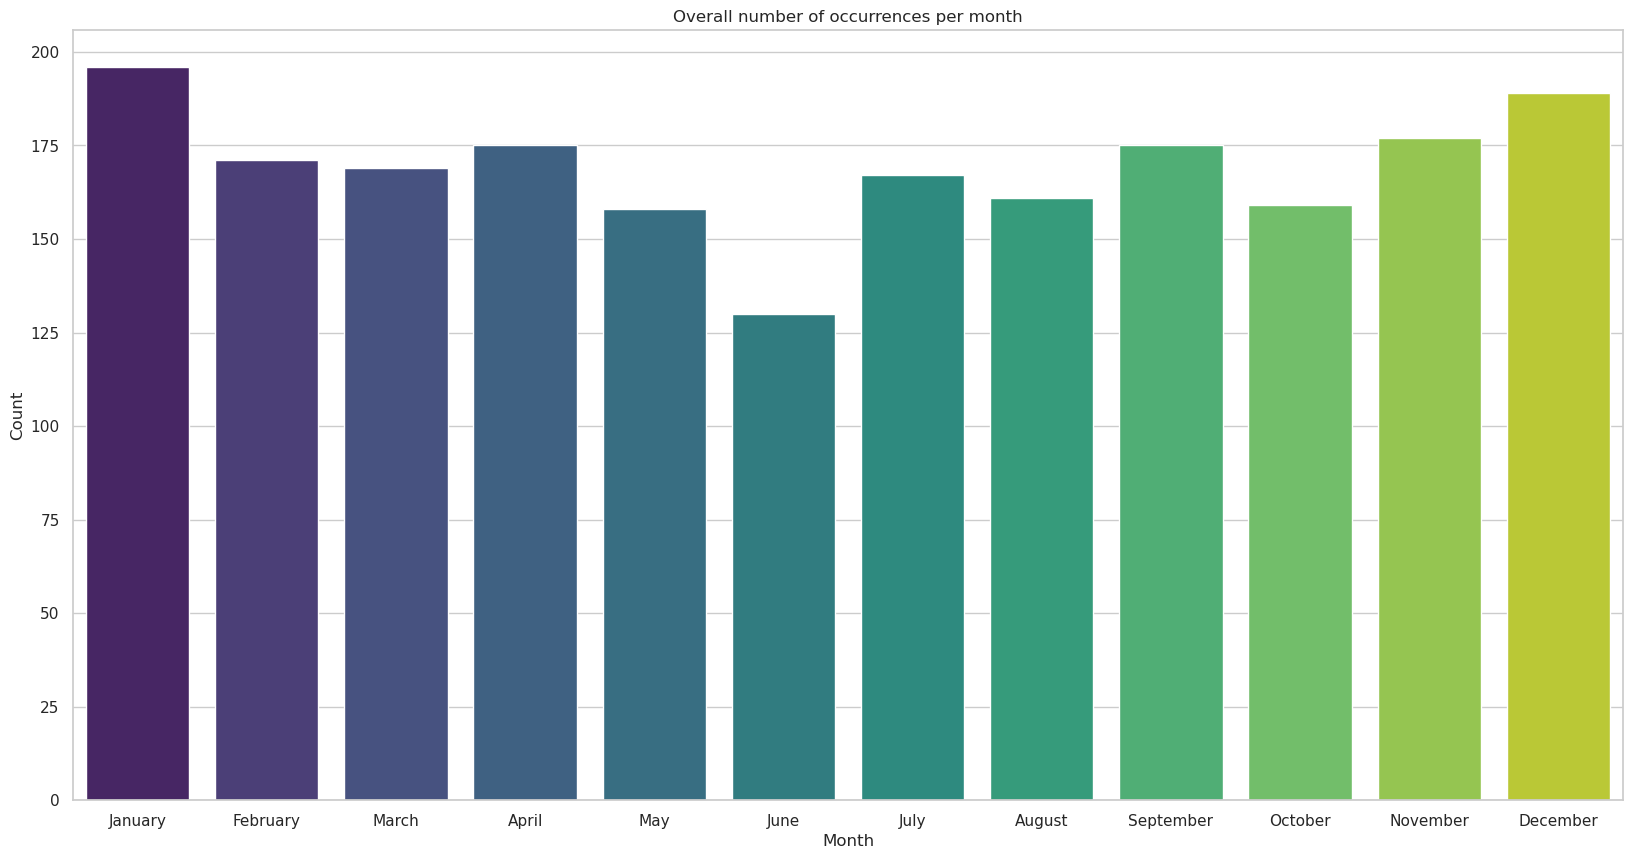

In [23]:
plt.figure(figsize=(20, 10))
sns.countplot(data=occurrence_df, x=occurrence_df['dia_ocorrencia'].dt.month, palette='viridis')
plt.title('Overall number of occurrences per month')
plt.xlabel('Month')
plt.xticks(range(0, 12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.ylabel('Count')
plt.show()

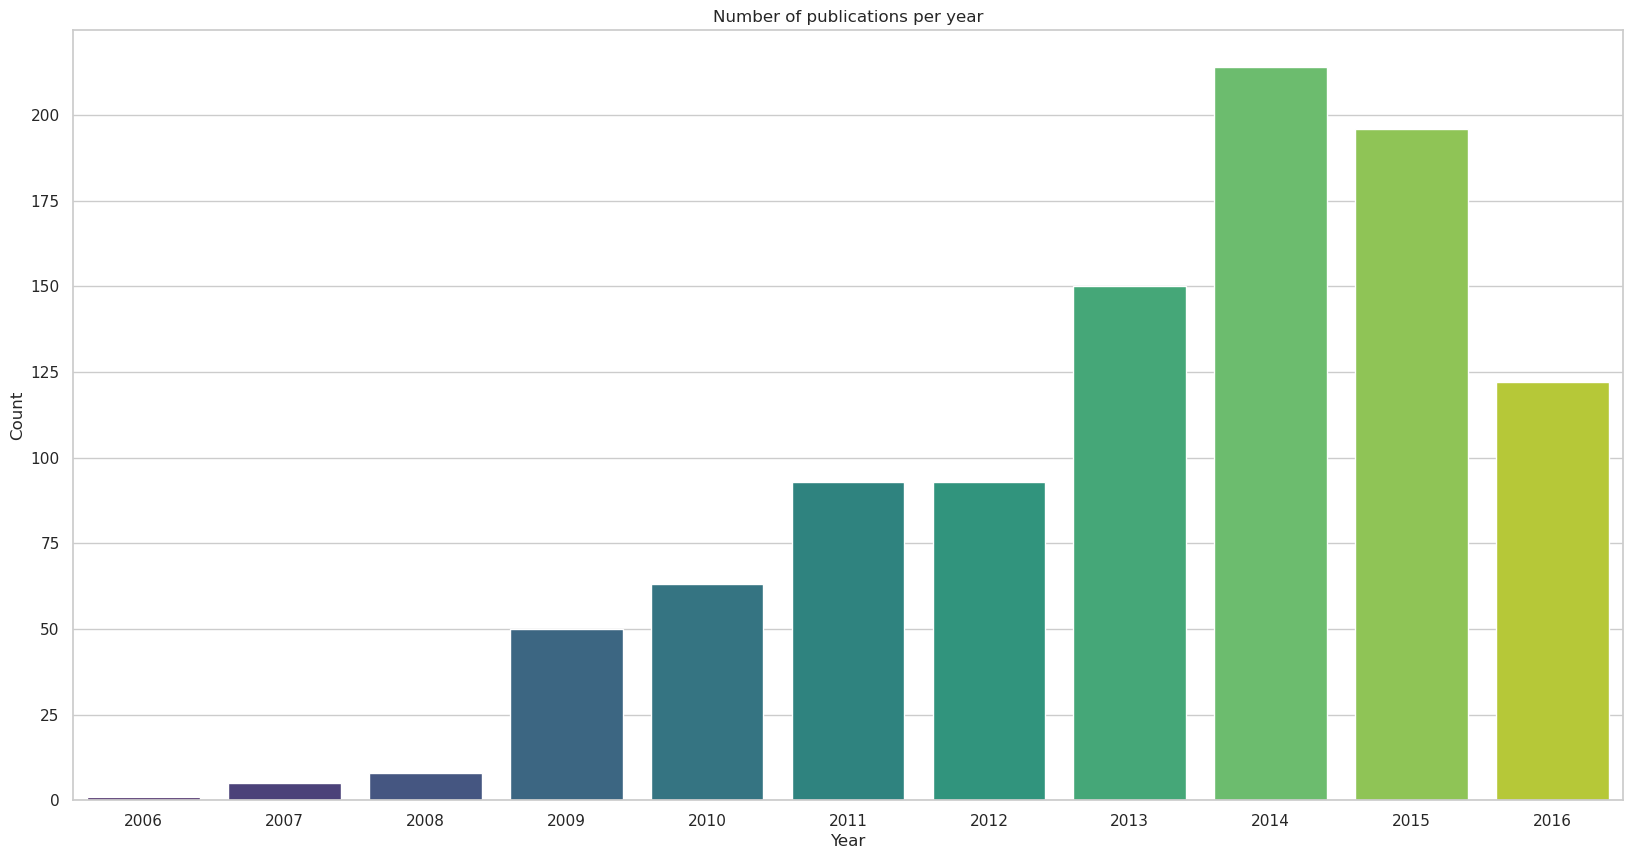

In [24]:
plt.figure(figsize=(20, 10))
sns.countplot(data=occurrence_df, x=occurrence_df['dia_publicacao'].dt.year, palette='viridis')
plt.title('Number of publications per year')
plt.xlabel('Year')
plt.xticks(ticks=(range(0, 11)), labels=(range(2006, 2017)))
plt.ylabel('Count')
plt.show()

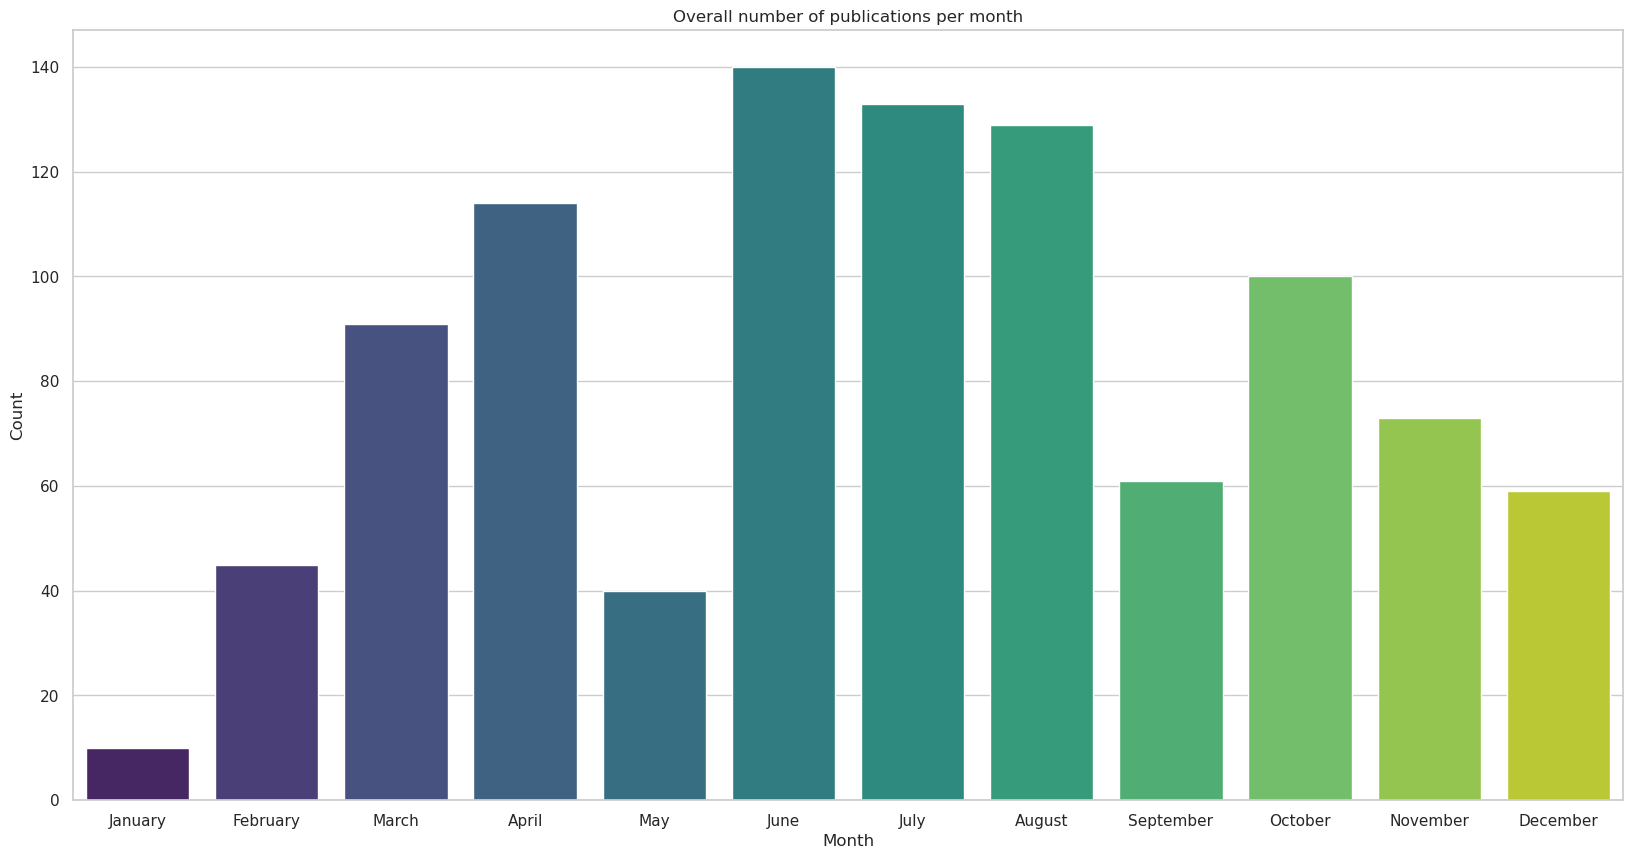

In [25]:
plt.figure(figsize=(20, 10))
sns.countplot(data=occurrence_df, x=occurrence_df['dia_publicacao'].dt.month, palette='viridis')
plt.title('Overall number of publications per month')
plt.xlabel('Month')
plt.xticks(range(0, 12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.ylabel('Count')
plt.show()

## Hypothesis statements

Once we know our data, it's time to start some further analysis and come up with hypothesis that might be taken into account to bring insights of the data. For storytelling easiness, the main hypothesis raised during this EDA process is stated bellow:

1. There is a large time delta between the ocurrence date and the publication date. Probably due to the investigation process.
2. Non-investigated occurrences is strongly correlated to missing information.
3. There is an increasing trend over time of occurrences. Indicating an increase in the air traffic.
4. The capacity for finishing occurrences investigation through years is increasing. The average amount of active occurrences stays the same.
5. Larger aircrafts tend to have more victims, given the trivial greater capacity.
6. Given the majority occurrences with particular aircraft, the majority of the occurrences might happen in national territory.

## Normal analysis

It is extremelly important to ensure if the data we're working with follows a normal distribution. There are several methods that assumes normal distributed data and that should be avoided otherwise.

For our normality test we used the [`normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) from `scipy.stats` module. The `normaltest` returns the sum $s^2$ + $k^2$, where $s$ is the z-score returned by `skewtest` and $k$ is the z-score returned by `kurtosistest`. It also returns a p-value representing a 2-sided $chi^2$ probability for the hypothesis test.

In our case, the null hypothesis is that our data distribution follows a normal distribution.

In [26]:
for col in aircraft_numerical_columns:
    k2, p = normaltest(aircraft_df[col])
    print(f'Normal test for {col}:', end=' ')
    if p < 0.05:
        print('The null hypothesis can be rejected (not normal)')
    else:
        print('The null hypothesis cannot be rejected (normal)')

Normal test for quantidade_motores: The null hypothesis cannot be rejected (normal)
Normal test for peso_maximo_decolagem: The null hypothesis can be rejected (not normal)
Normal test for quantidade_assentos: The null hypothesis cannot be rejected (normal)
Normal test for ano_fabricacao: The null hypothesis cannot be rejected (normal)
Normal test for quantidade_fatalidades: The null hypothesis cannot be rejected (normal)


In [27]:
for col in occurrence_numerical_columns:
    k2, p = normaltest(occurrence_df[col])
    print(f'Normal test for {col}:', end=' ')
    if p < 0.05:
        print('The null hypothesis can be rejected (not normal)')
    else:
        print('The null hypothesis cannot be rejected (normal)')

Normal test for quantidade_recomendacoes: The null hypothesis can be rejected (not normal)
Normal test for aeronaves_envolvidas: The null hypothesis can be rejected (not normal)


## Correlation analysis

In [28]:
aircraft_corr = aircraft_df[aircraft_numerical_columns].corr()
occurrence_corr = occurrence_df[occurrence_numerical_columns].corr()

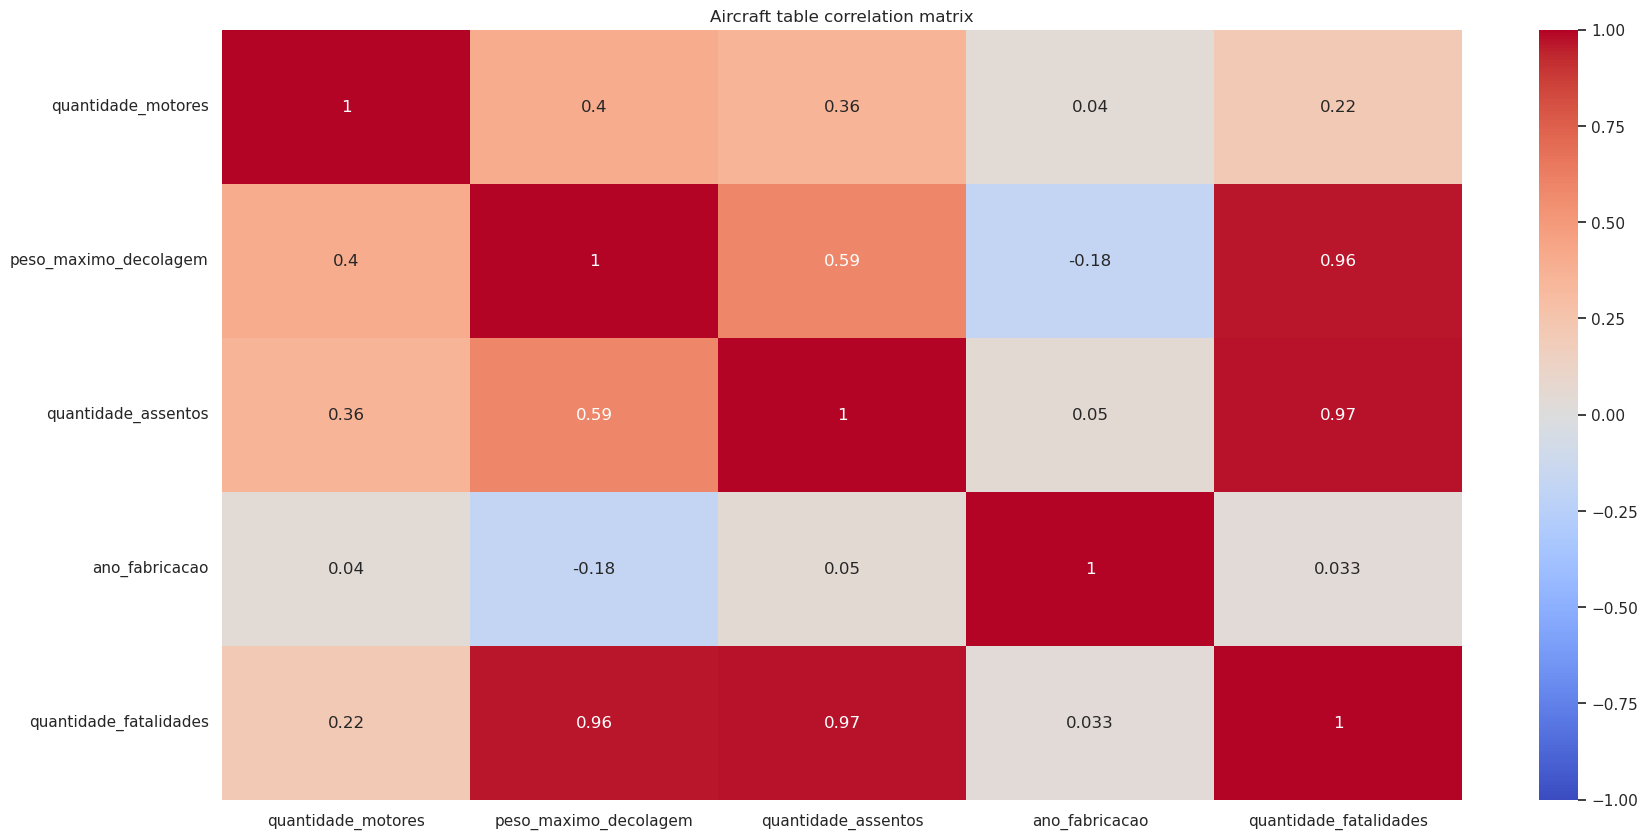

In [29]:
plt.figure(figsize=(20, 10))
sns.heatmap(aircraft_corr, vmin=-1.0, annot=True, cmap='coolwarm')
plt.title('Aircraft table correlation matrix')
plt.show()

For the aircraft table there is a strong positive correlation between the following variables:
* `quantidade_fatalidades` and `peso_maximo_decolagem`: 0.97
* `quantidade_fatalidades` and `quantidade_assentos`: 0.98
* `peso_maximo_decolagem` and `quantidade_assentos`: 0.56

This correlation is sort of trivial, given that aircraft with bigger seat number also has greater max weight capacity and a higher probability to have more victims given the total numer of seats. 

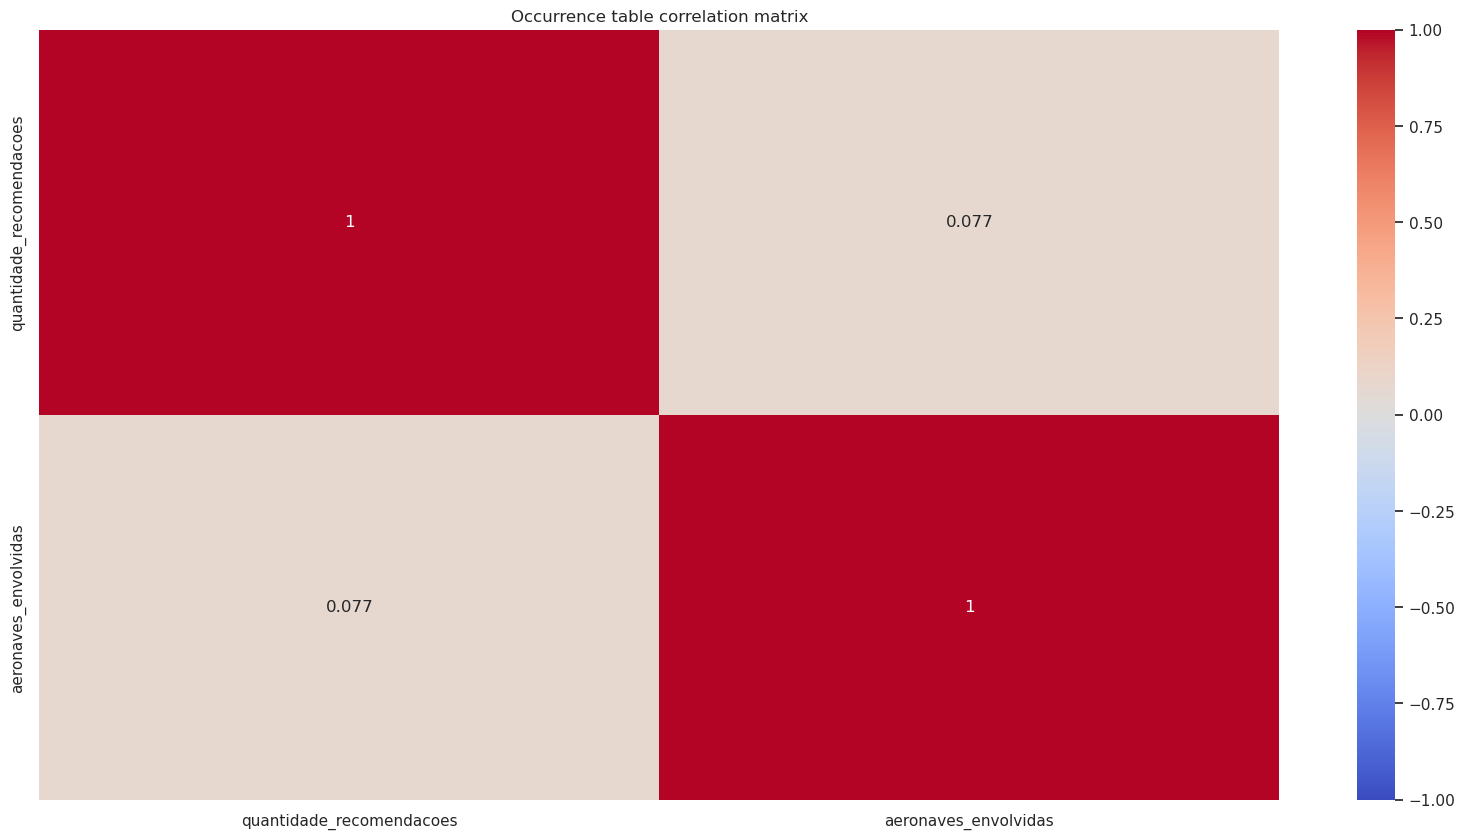

In [30]:
plt.figure(figsize=(20, 10))
sns.heatmap(occurrence_corr, vmin=-1.0, annot=True, cmap='coolwarm')
plt.title('Occurrence table correlation matrix')
plt.show()

There's no strong correlation for the numerical variables in the occurrence table.

## Temporal analysis

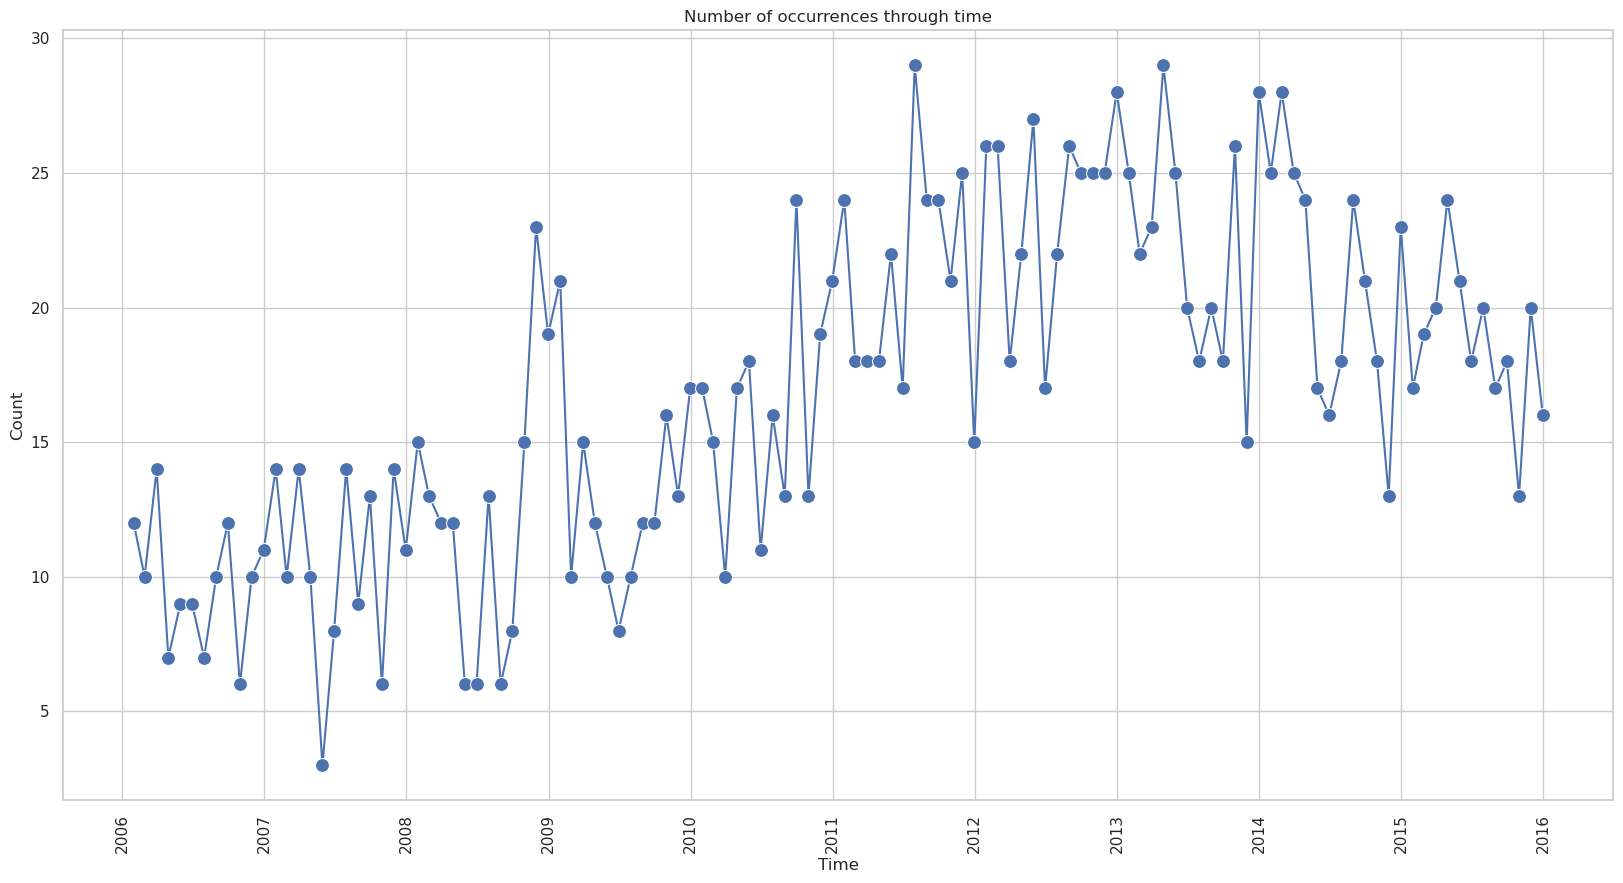

In [31]:
monthly_occurrence_df = occurrence_df.resample(rule='M', on='dia_ocorrencia').count()

plt.figure(figsize=(20, 10))
sns.lineplot(data=monthly_occurrence_df, x=monthly_occurrence_df.index, y='codigo_ocorrencia', marker='o', markersize=10)
plt.title(f'Number of occurrences through time')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

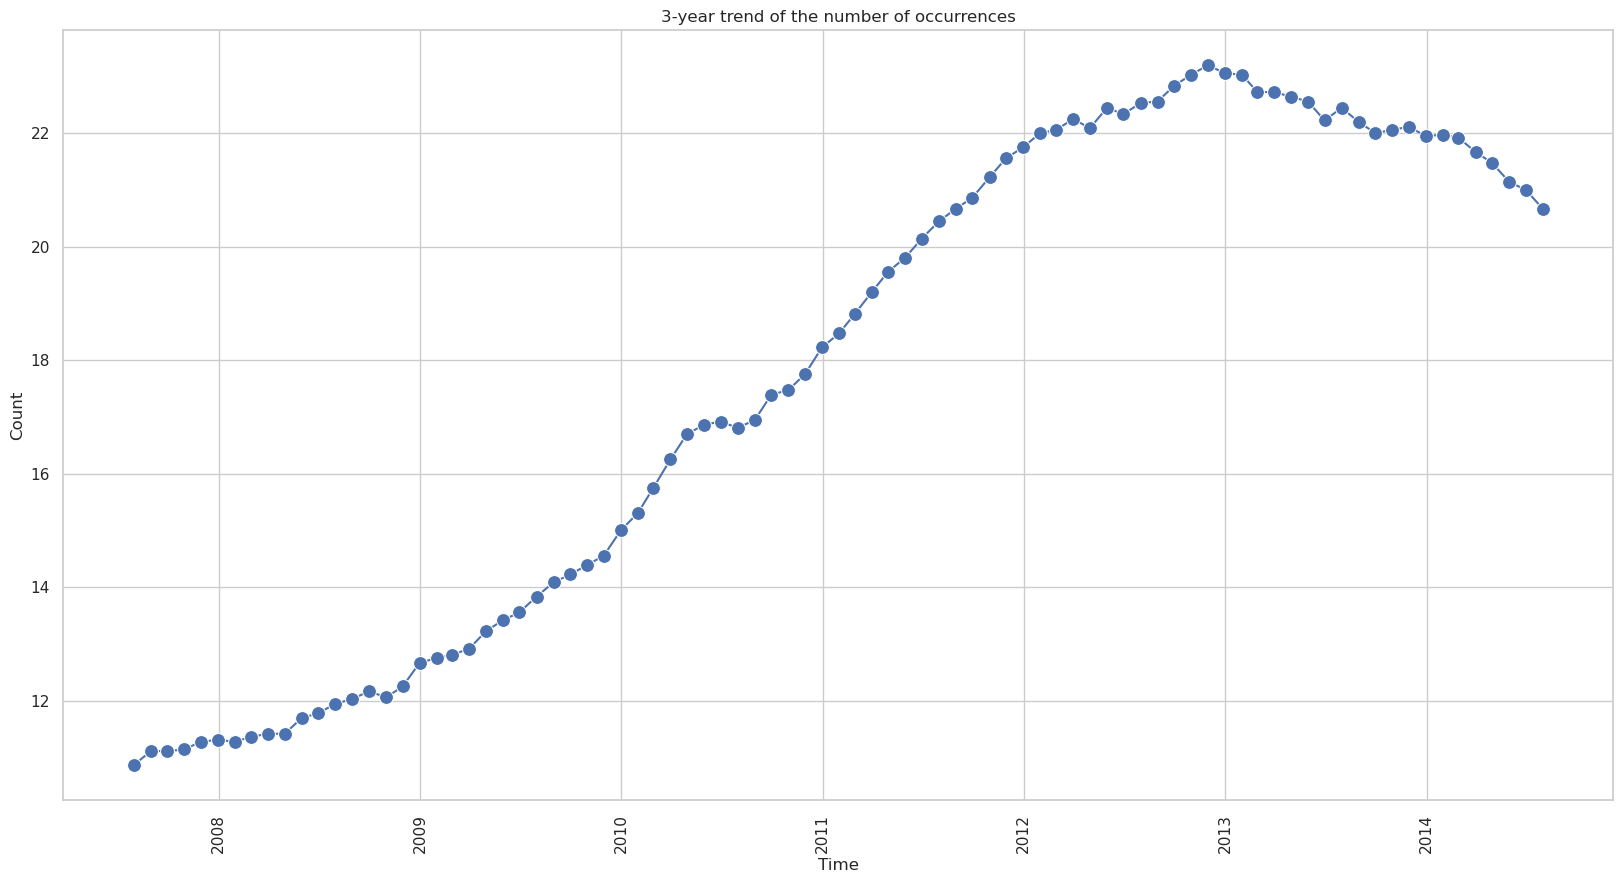

In [32]:
# Get the trend of the number of occurrences through time
trend_df = occurrence_df.resample(rule='M', on='dia_ocorrencia').count().rolling(window=36, center=True).mean()

plt.figure(figsize=(20, 10))
sns.lineplot(data=trend_df, x=trend_df.index, y='codigo_ocorrencia', marker='o', markersize=10)
plt.title(f'3-year trend of the number of occurrences')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

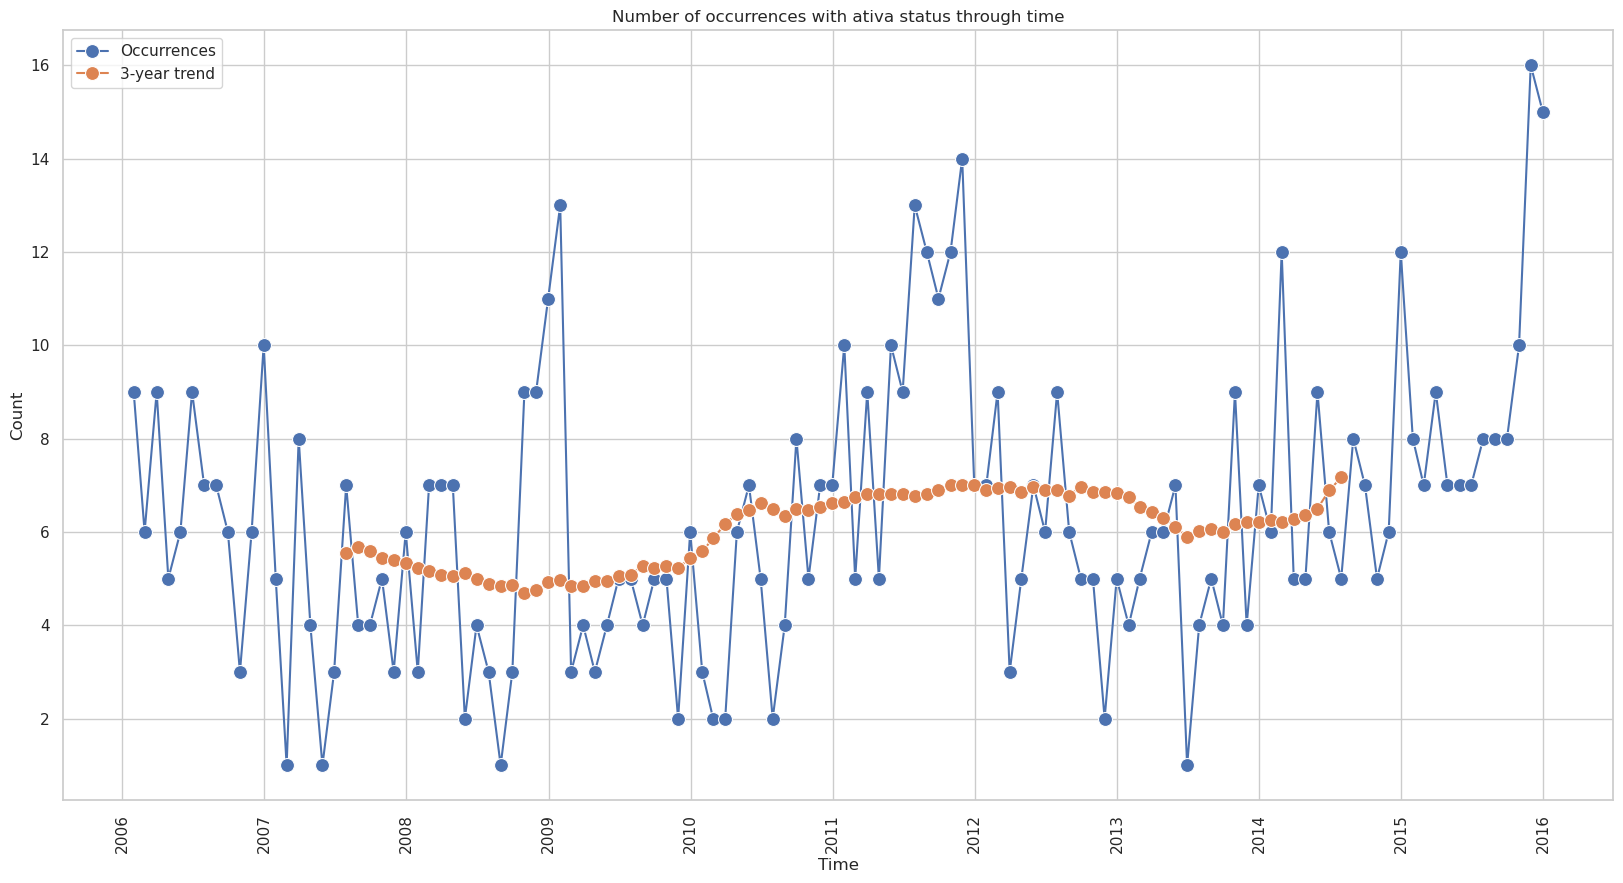

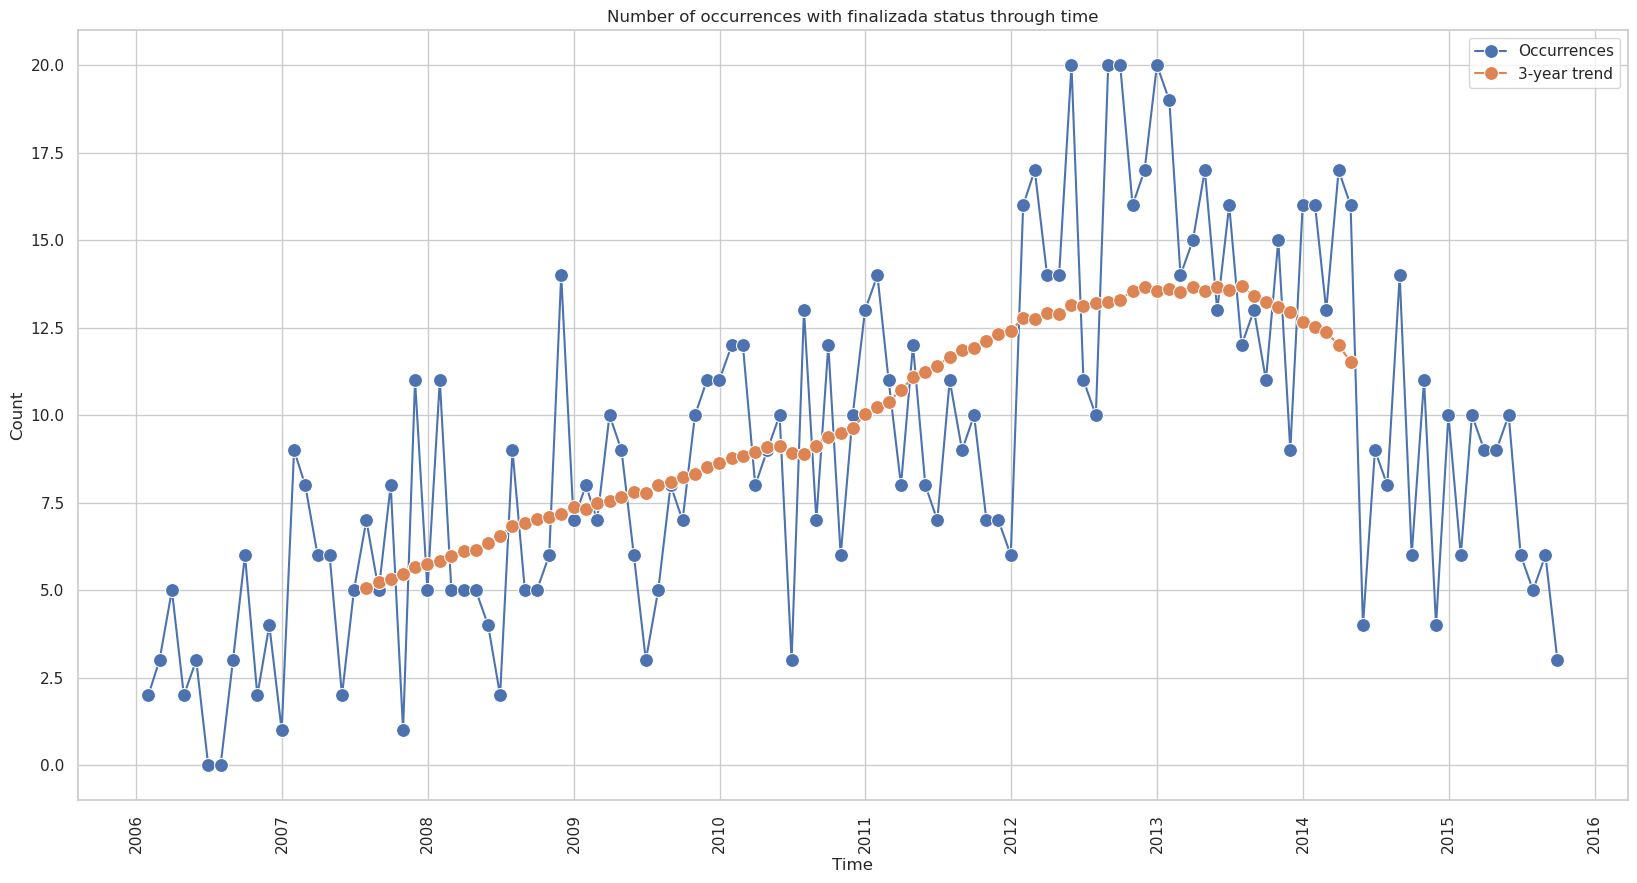

In [33]:
for status in ['ATIVA', 'FINALIZADA']:
    count_df = occurrence_df[occurrence_df['status_investigacao'] == status].resample(rule='M', on='dia_ocorrencia').count()
    trend_df = count_df.rolling(window=36, center=True).mean()

    plt.figure(figsize=(20, 10))
    sns.lineplot(data=count_df, x=count_df.index, y='codigo_ocorrencia', marker='o', markersize=10, label='Occurrences')
    sns.lineplot(data=trend_df, x=trend_df.index, y='codigo_ocorrencia', marker='o', markersize=10, label='3-year trend')
    plt.title(f'Number of occurrences with {status.lower()} status through time')
    plt.xlabel('Time')
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.legend()
    plt.show()


In [34]:
delta_time = occurrence_df['dia_publicacao'] - occurrence_df['dia_ocorrencia']
delta_time = delta_time.dt.days

delta_time.describe().round(1)

count     995.0
mean      773.3
std       611.8
min         7.0
25%       317.5
50%       577.0
75%      1028.5
max      3589.0
dtype: float64

In [35]:
# Remove outliers for a better visualization
q1 = delta_time.quantile(0.25)
q3 = delta_time.quantile(0.75)
iqr = q3 - q1

outliers = delta_time[(delta_time < q1 - 1.5 * iqr) | (delta_time > q3 + 1.5 * iqr)]

delta_time = delta_time[~delta_time.isin(outliers)]

delta_time.describe().round(1)

count     953.0
mean      692.0
std       477.2
min         7.0
25%       311.0
50%       548.0
75%       955.0
max      2092.0
dtype: float64

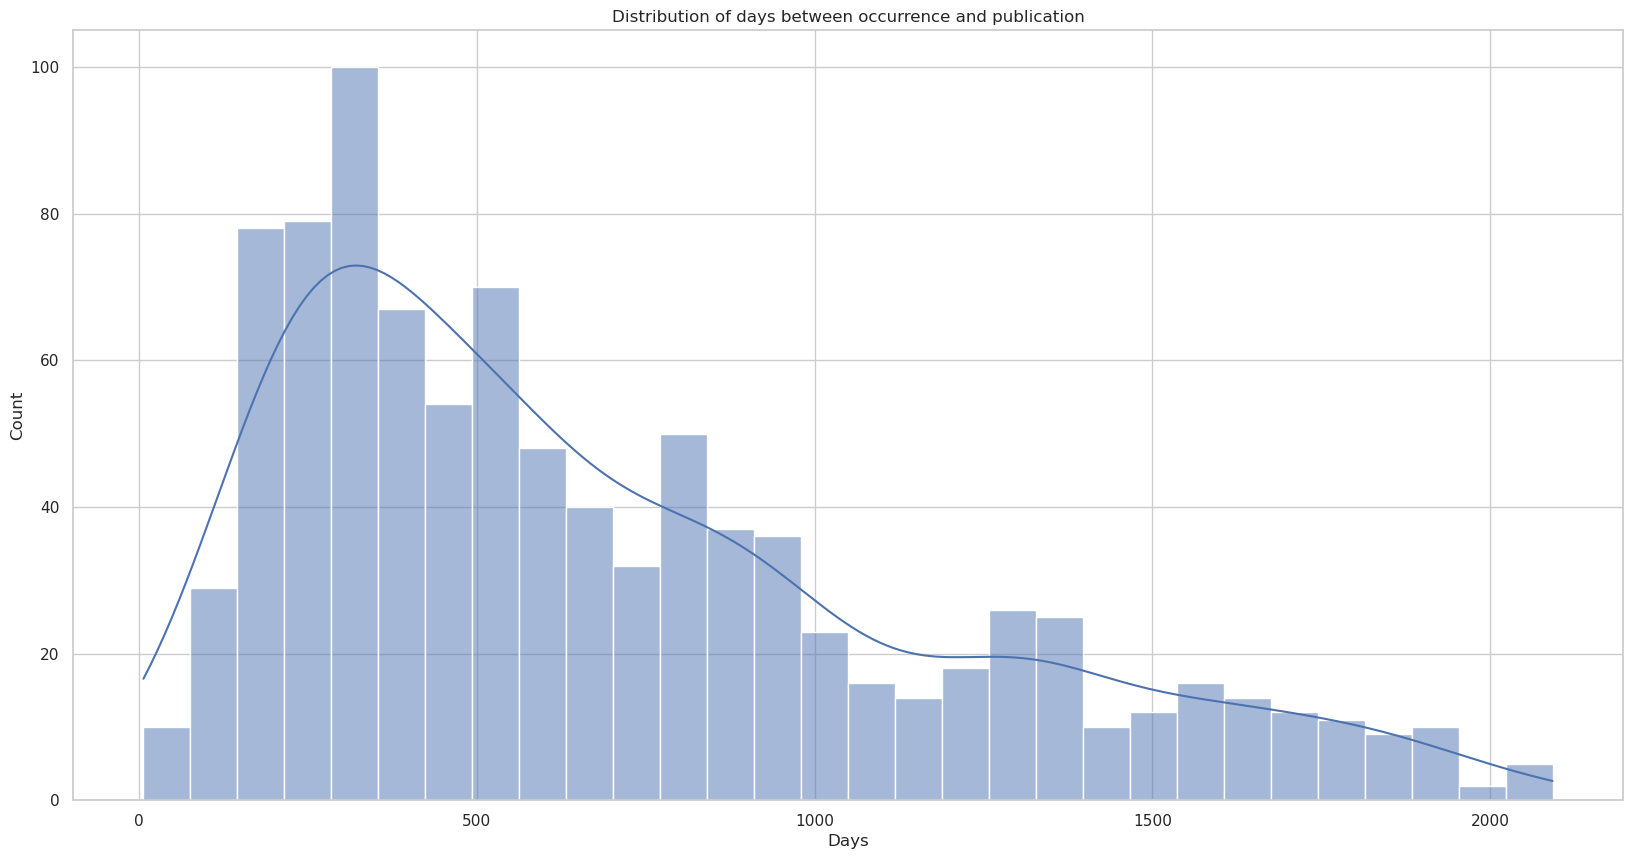

In [36]:
plt.figure(figsize=(20, 10))
sns.histplot(data=delta_time, bins=30, kde=True)
plt.title('Distribution of days between occurrence and publication')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

Another good investigation is identify on aircraft table information that might imply in the longer delay between occurrence date and publication date.

In [37]:
delta_time_df = pd.merge(occurrence_df, aircraft_df, on='codigo_ocorrencia', how='left')
delta_time_df['delta_time'] = delta_time
delta_time_df.head()

codigo_ocorrencia    classificacao                       tipo  localidade  \
0              47965         ACIDENTE      FALHA DO MOTOR EM VOO   ARIQUEMES   
1              50313  INCIDENTE GRAVE             POUSO SEM TREM      CACOAL   
2              34078         ACIDENTE  PERDA DE CONTROLE NO SOLO  CEREJEIRAS   
3              44988         ACIDENTE                POUSO LONGO     AMAJARI   
4              38855         ACIDENTE   PERDA DE CONTROLE EM VOO      ACEGUÁ   

   uf    pais aerodromo dia_ocorrencia             horario  sera_investigada  \
0  RO  BRASIL      SJOG     2013-05-05 2023-01-26 11:00:00             False   
1  RO  BRASIL      SSKW     2013-11-25 2023-01-26 12:32:00              True   
2  RO  BRASIL       NaN     2008-08-07 2023-01-26 15:10:00              True   
3  RR  BRASIL       NaN     2011-08-11 2023-01-26 17:00:00              True   
4  RS  BRASIL       NaN     2009-12-28 2023-01-26 17:30:00              True   

   ... categoria_registro categoria_aviacao origem_voo  destino_voo  \
0  ...                PET      EXPERIMENTAL        NaN          NaN   
1  ...                TPX        TÁXI AÉREO       SBJI         SSKW   
2  ...                TPX        TÁXI AÉREO       SWKK         SWRL   
3  ...                TPX        TÁXI AÉREO        NaN          NaN   
4  ...                SAE     ESPECIALIZADA        NaN          NaN   

         fase_operacao  tipo_operacao   nivel_dano  quantidade_fatalidades  \
0  CIRCUITO DE TRÁFEGO   EXPERIMENTAL  SUBSTANCIAL                     NaN   
1                POUSO     TÁXI AÉREO  SUBSTANCIAL                     NaN   
2   CORRIDA APÓS POUSO     TÁXI AÉREO  SUBSTANCIAL                     NaN   
3   CORRIDA APÓS POUSO     TÁXI AÉREO  SUBSTANCIAL                     NaN   
4            DECOLAGEM  ESPECIALIZADA  SUBSTANCIAL                     1.0   

  dia_extracao_y  delta_time  
0     2016-07-30         NaN  
1     2016-07-30       133.0  
2     2016-07-30         NaN  
3     2016-07-30       406.0  
4     2016-07-30         NaN  

[5 rows x 41 columns]

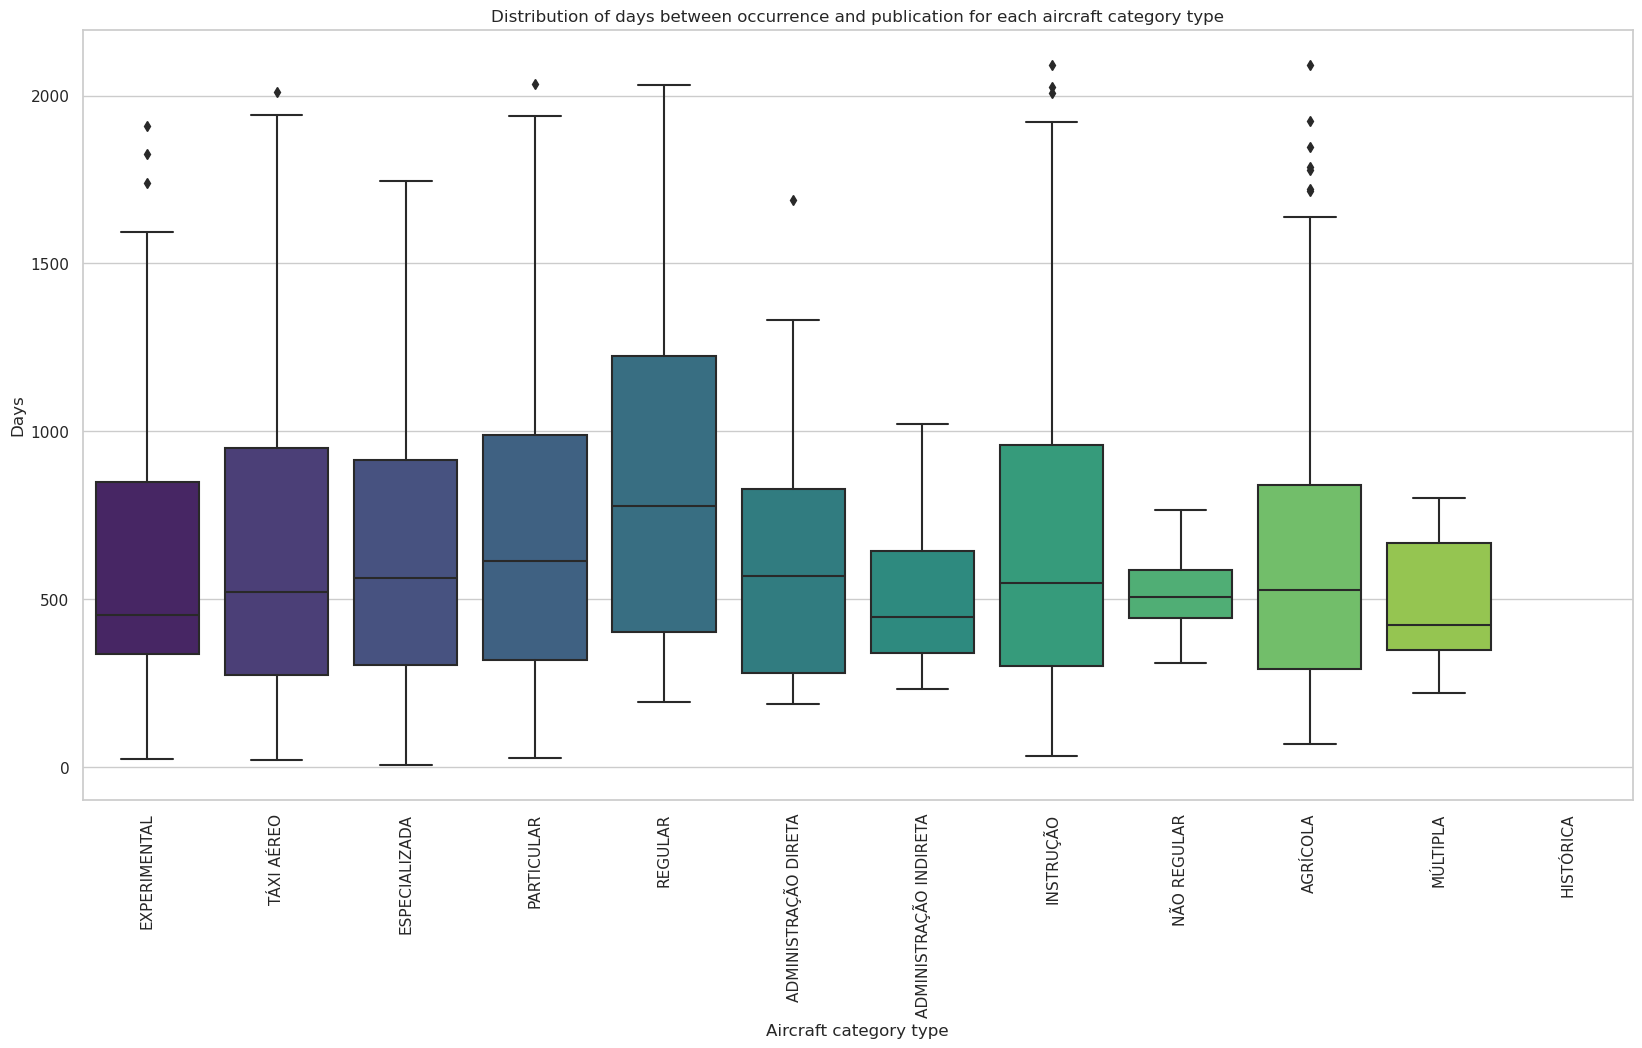

In [38]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=delta_time_df, x='categoria_aviacao', y='delta_time', palette='viridis', )
plt.title('Distribution of days between occurrence and publication for each aircraft category type')
plt.xlabel('Aircraft category type')
plt.ylabel('Days')
plt.xticks(rotation=90)
plt.show()

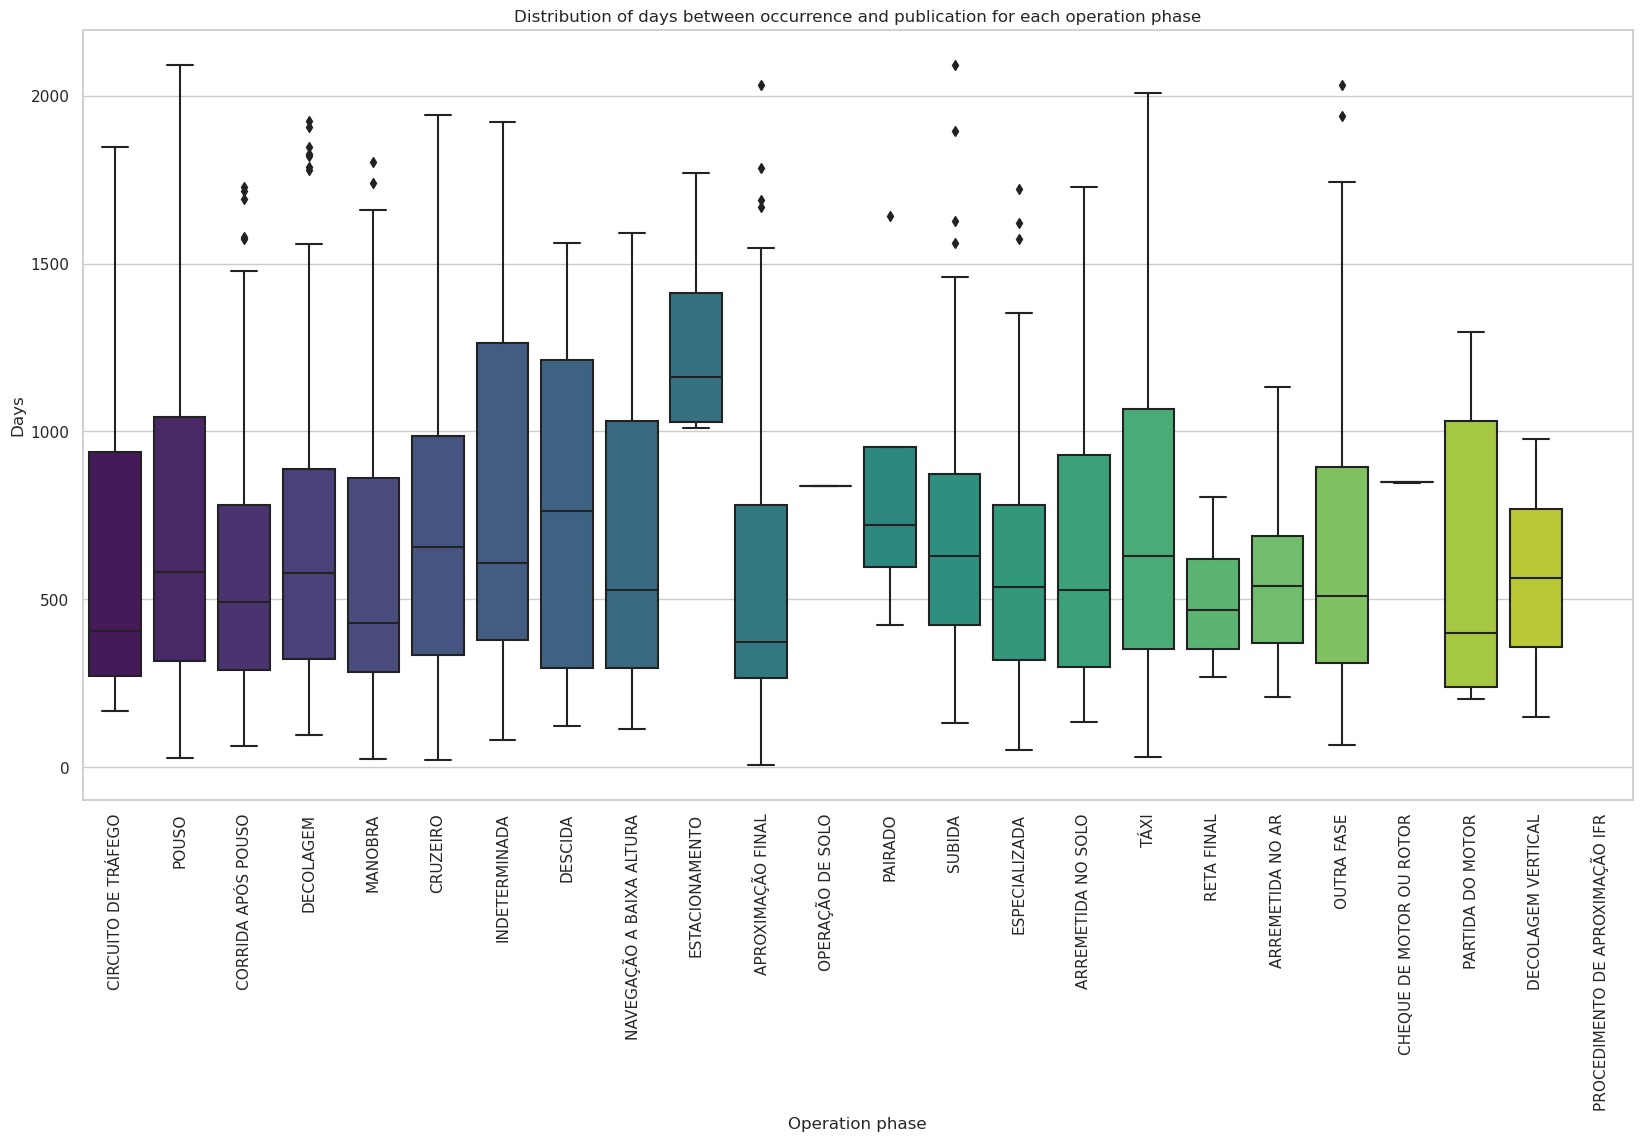

In [39]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=delta_time_df, x='fase_operacao', y='delta_time', palette='viridis', )
plt.title('Distribution of days between occurrence and publication for each operation phase')
plt.xlabel('Operation phase')
plt.ylabel('Days')
plt.xticks(rotation=90)
plt.show()

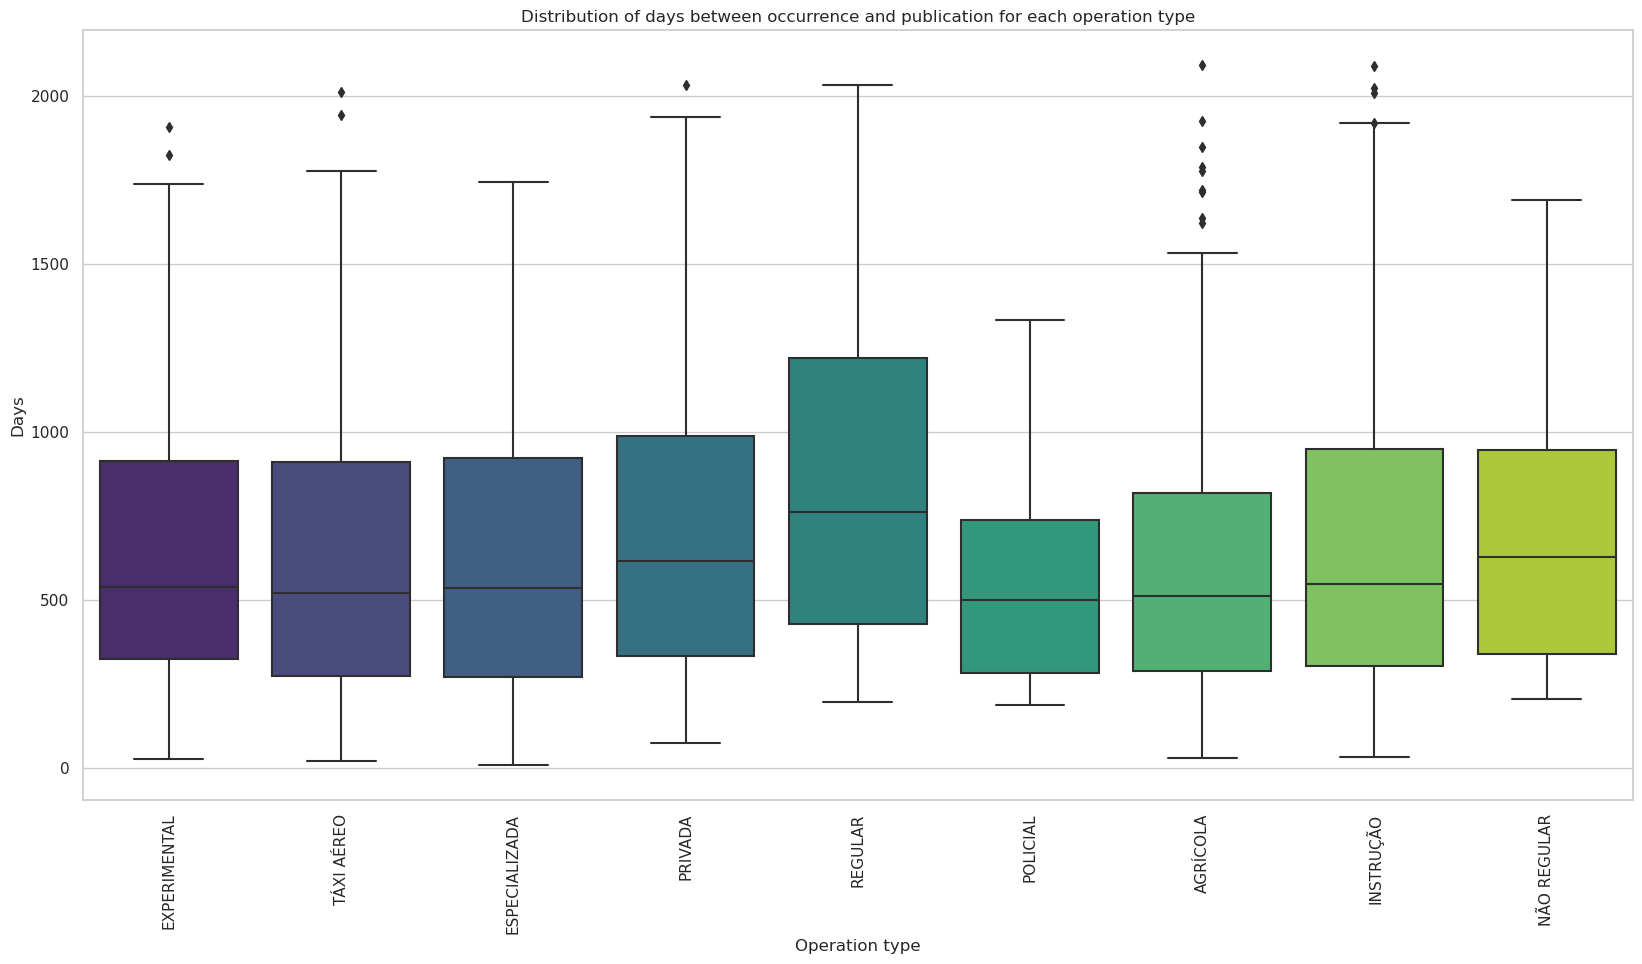

In [40]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=delta_time_df, x='tipo_operacao', y='delta_time', palette='viridis', )
plt.title('Distribution of days between occurrence and publication for each operation type')
plt.xlabel('Operation type')
plt.ylabel('Days')
plt.xticks(rotation=90)
plt.show()

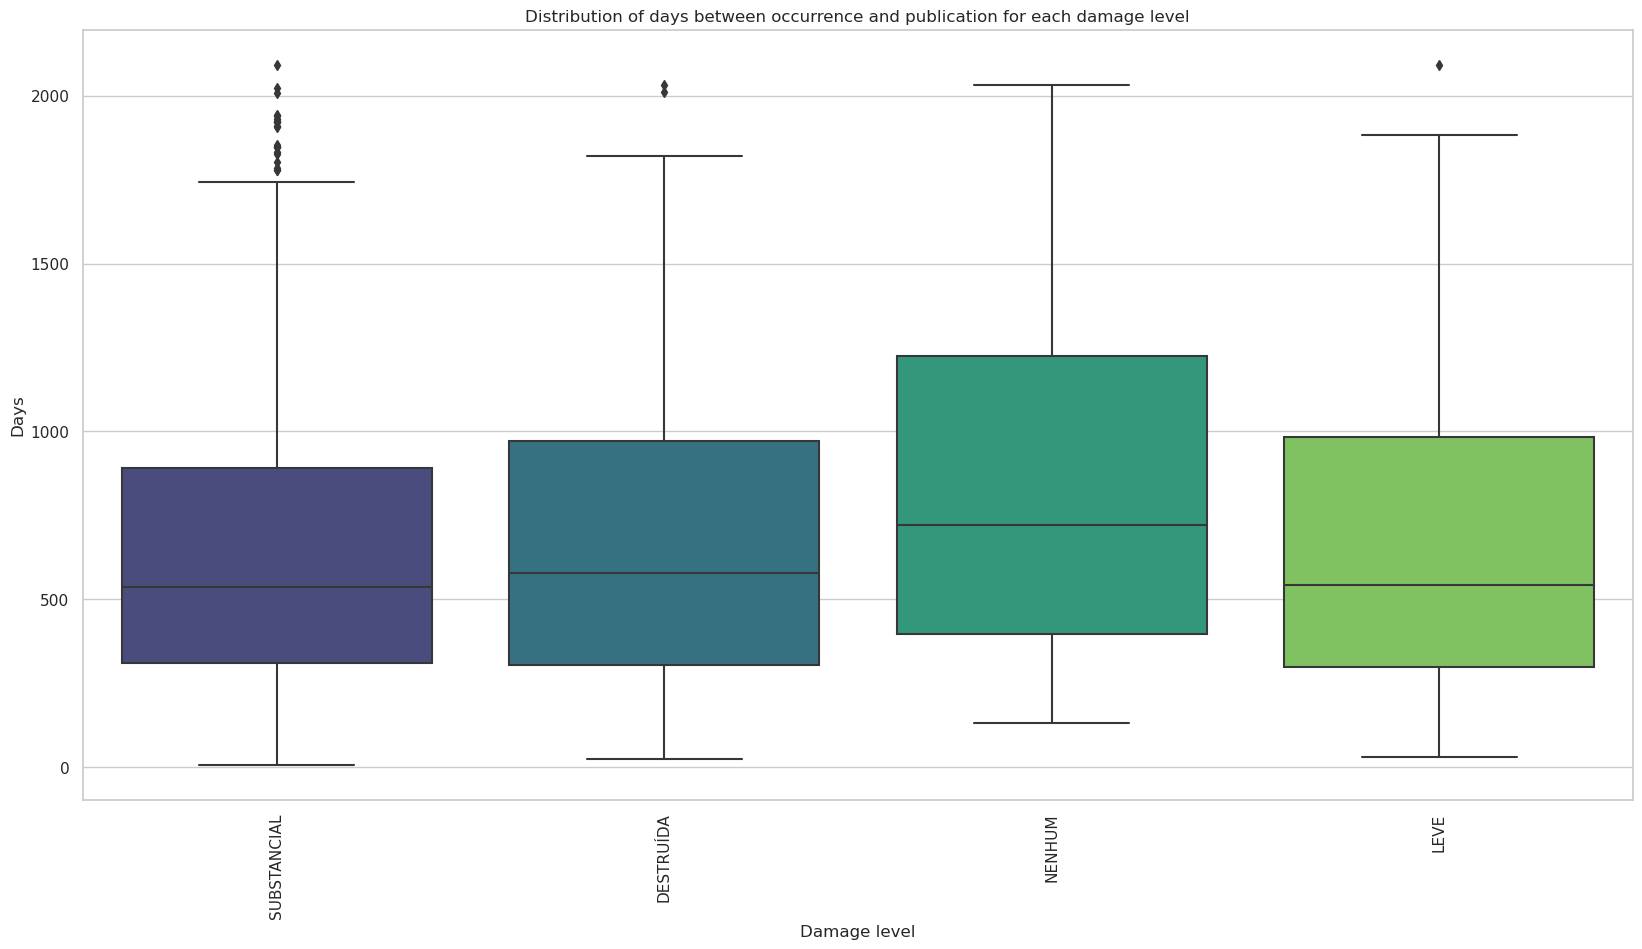

In [41]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=delta_time_df, x='nivel_dano', y='delta_time', palette='viridis', )
plt.title('Distribution of days between occurrence and publication for each damage level')
plt.xlabel('Damage level')
plt.ylabel('Days')
plt.xticks(rotation=90)
plt.show()

Our boxplot analysis found that the operation phase can imply the delta time between the occurrence date and publication date. For example, occurrences in the parking phase are, on average, longer than all other phases. While occurrences in the final approximation phase are, on average, shorter than all other phases.

## Geographical analysis

In [42]:
geolocator = Nominatim(user_agent='my_application')

# We'll use the coordinates to set the map's center
brazil = geolocator.geocode('Brazil')

In [43]:
aircraft_df.head()

codigo_aeronave  codigo_ocorrencia matricula  codigo_operador equipamento  \
0                4              45602     PPGXE              241       AVIÃO   
1               40              53551     PPGSZ              160       AVIÃO   
2              118              43721     PTCMT             1232       AVIÃO   
3              130              35556     PTEQI             3992       AVIÃO   
4              191              32579     PPVMM             4365       AVIÃO   

                    fabricante    modelo tipo_motor  quantidade_motores  \
0  NEIVA INDUSTRIA AERONAUTICA      56-C     PISTÃO                 1.0   
1  NEIVA INDUSTRIA AERONAUTICA      56-C     PISTÃO                 1.0   
2               BEECH AIRCRAFT    95-B55     PISTÃO                 2.0   
3  NEIVA INDUSTRIA AERONAUTICA  EMB-721C     PISTÃO                 1.0   
4               BOEING COMPANY   737-241       JATO                 2.0   

   peso_maximo_decolagem  ...  pais_registro  categoria_registro  \
0                  660.0  ...         BRASIL                 PRI   
1                  660.0  ...         BRASIL                 PRI   
2                 2310.0  ...         BRASIL                 TPX   
3                 1633.0  ...         BRASIL                 TPP   
4                52389.0  ...         BRASIL                 TPR   

  categoria_aviacao origem_voo destino_voo       fase_operacao tipo_operacao  \
0         INSTRUÇÃO       SDPW        SDPW       INDETERMINADA     INSTRUÇÃO   
1         INSTRUÇÃO       SBBP        SBBP           DECOLAGEM     INSTRUÇÃO   
2        TÁXI AÉREO        NaN         NaN  CORRIDA APÓS POUSO    TÁXI AÉREO   
3        PARTICULAR       SNDU        SBSL  CORRIDA APÓS POUSO       PRIVADA   
4           REGULAR        NaN         NaN              SUBIDA       REGULAR   

    nivel_dano quantidade_fatalidades dia_extracao  
0  SUBSTANCIAL                    NaN   2016-07-30  
1         LEVE                    NaN   2016-07-30  
2  SUBSTANCIAL                    NaN   2016-07-30  
3         LEVE                    NaN   2016-07-30  
4       NENHUM                    NaN   2016-07-30  

[5 rows x 22 columns]

In [44]:
if os.path.exists(DATA_ROOT / 'aircraft_with_latlong.csv'):
    aircraft_df = pd.read_csv(DATA_ROOT / 'aircraft_with_latlong.csv')
else:
    aircraft_df.dropna(subset=['origem_voo', 'destino_voo'], inplace=True)

    aircraft_df['orig_latitude'] = aircraft_df['origem_voo'].apply(lambda x: geolocator.geocode(x).latitude if geolocator.geocode(x) else None)
    aircraft_df['orig_longitude'] = aircraft_df['origem_voo'].apply(lambda x: geolocator.geocode(x).longitude if geolocator.geocode(x) else None)

    aircraft_df['dest_latitude'] = aircraft_df['destino_voo'].apply(lambda x: geolocator.geocode(x).latitude if geolocator.geocode(x) else None)
    aircraft_df['dest_longitude'] = aircraft_df['destino_voo'].apply(lambda x: geolocator.geocode(x).longitude if geolocator.geocode(x) else None)

    aircraft_df.to_csv(DATA_ROOT / 'aircraft_with_latlong.csv', index=False)
    
aircraft_df.head()

codigo_aeronave  codigo_ocorrencia matricula  codigo_operador equipamento  \
0                4              45602     PPGXE              241       AVIÃO   
1               40              53551     PPGSZ              160       AVIÃO   
2              130              35556     PTEQI             3992       AVIÃO   
3              206              38376     PTKDW             3992       AVIÃO   
4              213              50332     PTNOE             3992       AVIÃO   

                    fabricante    modelo tipo_motor  quantidade_motores  \
0  NEIVA INDUSTRIA AERONAUTICA      56-C     PISTÃO                 1.0   
1  NEIVA INDUSTRIA AERONAUTICA      56-C     PISTÃO                 1.0   
2  NEIVA INDUSTRIA AERONAUTICA  EMB-721C     PISTÃO                 1.0   
3              CESSNA AIRCRAFT      182P     PISTÃO                 1.0   
4  NEIVA INDUSTRIA AERONAUTICA  EMB-711C     PISTÃO                 1.0   

   peso_maximo_decolagem  ...  destino_voo       fase_operacao tipo_operacao  \
0                  660.0  ...         SDPW       INDETERMINADA     INSTRUÇÃO   
1                  660.0  ...         SBBP           DECOLAGEM     INSTRUÇÃO   
2                 1633.0  ...         SBSL  CORRIDA APÓS POUSO       PRIVADA   
3                 1338.0  ...         SIBX  CORRIDA APÓS POUSO       PRIVADA   
4                 1202.0  ...         SBMG           DECOLAGEM       PRIVADA   

    nivel_dano quantidade_fatalidades dia_extracao orig_latitude  \
0  SUBSTANCIAL                    NaN   2016-07-30    -22.711722   
1         LEVE                    NaN   2016-07-30     52.161599   
2         LEVE                    NaN   2016-07-30     13.485351   
3  SUBSTANCIAL                    NaN   2016-07-30    -15.681573   
4  SUBSTANCIAL                    NaN   2016-07-30    -23.692076   

  orig_longitude dest_latitude dest_longitude  
0     -47.618083    -22.711722     -47.618083  
1       4.496657     52.161599       4.496657  
2      39.473543     -2.588991     -44.239408  
3     -55.955234    -21.096220     -50.243226  
4     -52.642383    -23.476114     -52.014685  

[5 rows x 26 columns]

In [45]:
aircraft_gdf = gpd.GeoDataFrame(aircraft_df, geometry=gpd.points_from_xy(aircraft_df.orig_longitude, aircraft_df.orig_latitude))
aircraft_gdf.dropna(subset=['orig_latitude', 'orig_longitude', 'dest_latitude', 'dest_longitude'], inplace=True)

In [46]:
world = Map(location=[brazil.latitude, brazil.longitude], zoom_start=4)

for _, row in aircraft_gdf.iterrows():
    Marker(location=[row.orig_latitude, row.orig_longitude], popup=row.origem_voo).add_to(world)
    Marker(location=[row.dest_latitude, row.dest_longitude], popup=row.destino_voo).add_to(world)
    PolyLine(locations=[(row.orig_latitude, row.orig_longitude), (row.dest_latitude, row.dest_longitude)], color='blue', weight=2, opacity=0.5).add_to(world)

world

In [47]:
if os.path.exists(DATA_ROOT / 'occurrence_with_latlong.csv'):
    occurrence_df = pd.read_csv(DATA_ROOT / 'occurrence_with_latlong.csv')
else:
    occurrence_df['latitude'] = occurrence_df['localidade'].apply(lambda x: geolocator.geocode(x.capitalize()).latitude if geolocator.geocode(x.capitalize()) else None)
    occurrence_df['longitude'] = occurrence_df['localidade'].apply(lambda x: geolocator.geocode(x.capitalize()).longitude if geolocator.geocode(x.capitalize()) else None)

    occurrence_df.to_csv(DATA_ROOT / 'occurrence_with_latlong.csv', index=False)

occurrence_df.head()

codigo_ocorrencia    classificacao                       tipo  localidade  \
0              47965         ACIDENTE      FALHA DO MOTOR EM VOO   ARIQUEMES   
1              50313  INCIDENTE GRAVE             POUSO SEM TREM      CACOAL   
2              34078         ACIDENTE  PERDA DE CONTROLE NO SOLO  CEREJEIRAS   
3              44988         ACIDENTE                POUSO LONGO     AMAJARI   
4              38855         ACIDENTE   PERDA DE CONTROLE EM VOO      ACEGUÁ   

   uf    pais aerodromo dia_ocorrencia              horario  sera_investigada  \
0  RO  BRASIL      SJOG     2013-05-05  2023-01-25 11:00:00             False   
1  RO  BRASIL      SSKW     2013-11-25  2023-01-25 12:32:00              True   
2  RO  BRASIL       NaN     2008-08-07  2023-01-25 15:10:00              True   
3  RR  BRASIL       NaN     2011-08-11  2023-01-25 17:00:00              True   
4  RS  BRASIL       NaN     2009-12-28  2023-01-25 17:30:00              True   

   ... status_investigacao     numero_relatorio relatorio_publicado  \
0  ...                 NaN                  NaN                True   
1  ...          FINALIZADA   IG-209/CENIPA/2013                True   
2  ...          FINALIZADA  A - 517/CENIPA/2016                True   
3  ...          FINALIZADA    A-105/CENIPA/2012                True   
4  ...               ATIVA            A DEFINIR                True   

   dia_publicacao quantidade_recomendacoes  aeronaves_envolvidas  saida_pista  \
0             NaN                        0                     1         True   
1      2014-04-07                        0                     1         True   
2      2016-07-07                        0                     1         True   
3      2012-09-20                        4                     1         True   
4             NaN                        0                     1         True   

   dia_extracao   latitude  longitude  
0    2016-07-30  -9.907652 -63.033069  
1    2016-07-30 -11.433300 -61.442050  
2    2016-07-30 -13.192425 -60.819245  
3    2016-07-30   3.652387 -61.419432  
4    2016-07-30 -31.869513 -54.161559  

[5 rows x 21 columns]

In [48]:
occurrence_gdf = gpd.GeoDataFrame(occurrence_df, geometry=gpd.points_from_xy(occurrence_df.longitude, occurrence_df.latitude))
occurrence_gdf.dropna(subset=['latitude', 'longitude'], inplace=True)

In [49]:
world = Map(location=[brazil.latitude, brazil.longitude], zoom_start=4)
HeatMap(data=occurrence_gdf[['latitude', 'longitude']], radius=15).add_to(world)
world

## Final thoughts and remarks

During this EDA analysis we confirm some of the hypothesis generated after the data characterization.

We also observed that the investigation average time is quite long (more than 1 year). Indicating that there might be room for investigation process improvements to speed it up.

Finally, our remarks showed that the vast majority of the occurrences happen in the national territory in the metropolis areas for particular airplanes.